# Equity Research AI Agent — Annisya Putri Ayudita

This model combines intrinsic valuation (FCFF DCF) and relative valuation (forward P/E multiples) to estimate a fair value range and price target. It uses historical financial statements with TTM as the base year, and derives intrinsic value through a WACC (CAPM-based) discounted cash flow, supported by Bear/Base/Bull scenario analysis and sensitivity analysis. In parallel, the model applies a forward P/E multiples framework with Bear/Base/Bull cases, and produces a blended target price using configurable weights between the multiples based value and the DCF value

**Key Features**:
1. Historical Financial Data (Income Statement, Balance Sheet, Cash Flow)
2. TTM (Trailing Twelve Months) as Base Year
3. Ratio Analysis
4. FCFF Calculation
5. WACC via CAPM
6. DCF and Sensitivity Analysis
7. Market multiples Valuation using Forward P/E
8. Blended Price Target (DCF + multiples weighting)
9. Outputs & Reporting

In [27]:
!pip -q install yfinance pandas numpy openpyxl matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime, timedelta
from IPython.display import display, Markdown
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# 1. CONFIGURATION FOR FINANCIAL MODEL

TICKER = "GOOGL"
OUTPUT_NAME = f"Equity_Research_AI_Agent_{TICKER}"
AMOUNT_UNIT = 1_000_000  
FORECAST_YEARS = 5  
MIN_YEARS_FOR_CAGR = 3

# Terminal Assumptions
TERMINAL_GROWTH_DEFAULT = 0.03
NORMALIZED_TAX_RATE = 0.21

STEADY_STATE = {
    'ebit_margin': 0.30,
    'da_pct': None,
    'capex_pct': None,
    'nwc_pct': None,}

# 2. SCENARIO FOR RECOMMENDATION 

DCF_ASSUMPTIONS = {
    'base': {
        'name': 'Base Case',
        'revenue_growth': [0.10, 0.09, 0.08, 0.065, 0.05],
        'terminal_growth': 0.030,
        'steady_ebit_margin': 0.30,
        'probability': 0.80 },
    'bull': {
        'name': 'Bull Case',
        'revenue_growth': [0.12, 0.11, 0.10, 0.08, 0.065],
        'terminal_growth': 0.035,
        'steady_ebit_margin': 0.32,
        'probability': 0.10  },
    'bear': {
        'name': 'Bear Case',
        'revenue_growth': [0.07, 0.06, 0.05, 0.04, 0.03],
        'terminal_growth': 0.025,
        'steady_ebit_margin': 0.27,
        'probability': 0.10  }
}

UPSIDE_BUY_THRESHOLD = 0.15
DOWNSIDE_SELL_THRESHOLD = -0.15

def pick_row(df: pd.DataFrame, candidates: List[str]) -> pd.Series:
    """Return the first matching row by name; NaNs if not found."""
    if df is None or df.empty:
        return pd.Series(dtype='float64')
    for c in candidates:
        if c in df.index:
            return df.loc[c]
    return pd.Series(index=df.columns, dtype='float64')

def to_year_sorted_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Convert date columns to year ints and sort ascending."""
    if df is None or df.empty:
        return pd.DataFrame()
    new_cols = []
    for c in df.columns:
        try:
            year = pd.to_datetime(c).year
        except:
            year = int(str(c)[:4])
        new_cols.append(year)
    df = df.copy()
    df.columns = new_cols
    return df.loc[:, sorted(df.columns)]

def yoy_pct(series: pd.Series) -> pd.Series:
    """Year-over-year percent change."""
    return series.replace(0, np.nan).pct_change() * 100

def cagr_calc(series: pd.Series, min_years: int = 3) -> float:
    """Calculate CAGR from a series."""
    s = series.dropna()
    if len(s) >= min_years and s.iloc[0] > 0:
        return (s.iloc[-1] / s.iloc[0]) ** (1 / (len(s) - 1)) - 1
    elif len(s) >= 2:
        return s.pct_change().iloc[-1] if not pd.isna(s.pct_change().iloc[-1]) else 0.0
    return 0.0

def format_header_years(years: List[int], last_actual: int) -> List[str]:
    return [f"FY{y}{'(A)' if y <= last_actual else '(F)'}" for y in years]

def to_millions(value: float) -> float:
    return value / AMOUNT_UNIT if value else 0

def safe_float(val):
    if isinstance(val, pd.Series):
        val = val.iloc[0] if len(val) > 0 else 0
    return float(val) if pd.notna(val) else 0

def calc_3yr_avg(series: pd.Series, years: List[int]) -> float:
    vals = [safe_float(series.get(y, np.nan)) for y in years]
    vals = [v for v in vals if not np.isnan(v) and v != 0]
    return np.mean(vals) if vals else 0.0

def fade_ratio(yr: int, start_yr: int, end_yr: int, avg_3yr: float, steady: float) -> float:
    """Apply fade rule: years before start_yr = 3yr avg, then linear fade to steady by end_yr."""
    if yr < start_yr:
        return avg_3yr
    elif yr >= end_yr:
        return steady
    else:
        total_fade_years = end_yr - start_yr + 1
        progress = (yr - start_yr + 1) / total_fade_years
        return avg_3yr + (steady - avg_3yr) * progress

print(f"Configuration: {TICKER}, {FORECAST_YEARS} year forecast (2026-2030)")

Configuration: GOOGL, 5 year forecast (2026-2030)


In [28]:
# 3. RETRIEVE DATA FROM YAHOO FINANCE

tk = yf.Ticker(TICKER)

# Annual Financial Statements
inc = to_year_sorted_columns(tk.financials)
bs = to_year_sorted_columns(tk.balance_sheet)
cf = to_year_sorted_columns(tk.cashflow)

# Quarterly Financial Statements (for TTM)
inc_q = tk.quarterly_financials
bs_q = tk.quarterly_balance_sheet
cf_q = tk.quarterly_cashflow

# Company Info
info = tk.get_info() or {}
fast_info = getattr(tk, 'fast_info', None)

if inc.empty or bs.empty or cf.empty:
    raise ValueError(f"Incomplete data for {TICKER}. Check ticker availability.")

all_years = sorted(set(inc.columns) | set(bs.columns) | set(cf.columns))
last_actual_year = max(all_years)
currency = getattr(fast_info, 'currency', None) or info.get('currency', 'USD')

# Income Statement 
revenue = pick_row(inc, ['Total Revenue', 'Revenue', 'Operating Revenue'])
cost_of_revenue = pick_row(inc, ['Cost Of Revenue', 'Cost of Revenue'])
gross_profit = pick_row(inc, ['Gross Profit'])
if gross_profit.isna().all():
    gross_profit = revenue - cost_of_revenue

operating_income = pick_row(inc, ['Operating Income', 'Operating Income Loss'])
net_income = pick_row(inc, ['Net Income'])
pretax_income = pick_row(inc, ['Income Before Tax', 'Pretax Income'])
tax_expense = pick_row(inc, ['Income Tax Expense'])
interest_expense = pick_row(inc, ['Interest Expense', 'Interest Expense Non Operating']).abs()

dep_amort_inc = pick_row(inc, ['Depreciation And Amortization', 'Depreciation',
    'Depreciation Amortization Depletion', 'Depreciation And Depletion'])

# Cash Flow Statement 
operating_cf = pick_row(cf, ['Operating Cash Flow', 'Total Cash From Operating Activities'])
capex_raw = pick_row(cf, ['Capital Expenditure'])
capex = capex_raw.abs()

da_cf = pick_row(cf, ['Depreciation And Amortization', 'Depreciation',
                       'Depreciation Amortization Depletion']).abs()
if da_cf.isna().all():
    da_cf = dep_amort_inc.abs()

# Balance Sheet
total_assets = pick_row(bs, ['Total Assets'])
total_equity = pick_row(bs, ['Total Stockholder Equity', 'Total Equity Gross Minority Interest'])
total_liabilities = pick_row(bs, ['Total Liabilities Net Minority Interest', 'Total Liabilities'])
if total_liabilities.isna().all():
    total_liabilities = total_assets - total_equity

total_debt = pick_row(bs, ['Total Debt'])
if total_debt.isna().all():
    long_debt = pick_row(bs, ['Long Term Debt'])
    short_debt = pick_row(bs, ['Short Term Debt', 'Current Debt', 'Short Long Term Debt'])
    total_debt = long_debt.fillna(0) + short_debt.fillna(0)

cash_eq = pick_row(bs, ['Cash And Cash Equivalents', 'Cash'])
current_assets = pick_row(bs, ['Total Current Assets'])
current_liabilities = pick_row(bs, ['Total Current Liabilities'])

# EBITDA
ebitda = operating_income.fillna(0) + da_cf.fillna(0)

# Non-Cash Working Capital
non_cash_wc = (current_assets.fillna(0) - cash_eq.fillna(0)) - current_liabilities.fillna(0)
delta_wc = non_cash_wc.diff()

# Historical FCF
fcf_historical = operating_cf - capex

# TTM DATA (if the latest year is unavailable on Yahoo Finance)

def calculate_ttm(quarterly_df: pd.DataFrame, sum_quarters: bool = True) -> pd.Series:
    if quarterly_df is None or quarterly_df.empty:
        return pd.Series(dtype='float64')
    if sum_quarters:
        return quarterly_df.iloc[:, :4].sum(axis=1)
    else:
        return quarterly_df.iloc[:, 0]

def get_ttm_value(ttm_series: pd.Series, keys: List[str]) -> float:
    for key in keys:
        if key in ttm_series.index:
            val = ttm_series[key]
            if pd.notna(val):
                return float(val)
    return 0.0

def get_bs_4q_ago(quarterly_bs: pd.DataFrame) -> pd.Series:
    if quarterly_bs is None or quarterly_bs.empty:
        return pd.Series(dtype='float64')
    if quarterly_bs.shape[1] >= 5:
        return quarterly_bs.iloc[:, 4]
    elif quarterly_bs.shape[1] >= 4:
        return quarterly_bs.iloc[:, 3]
    else:
        return quarterly_bs.iloc[:, -1]

inc_ttm = calculate_ttm(inc_q, sum_quarters=True)
cf_ttm = calculate_ttm(cf_q, sum_quarters=True)
bs_latest = calculate_ttm(bs_q, sum_quarters=False)
bs_4q_ago = get_bs_4q_ago(bs_q)

ttm_available = not inc_ttm.empty

ttm_data = {}
if ttm_available:
    ttm_data['Total Revenue'] = get_ttm_value(inc_ttm, ['Total Revenue', 'Revenue', 'Operating Revenue'])
    ttm_data['Gross Profit'] = get_ttm_value(inc_ttm, ['Gross Profit'])
    if ttm_data['Gross Profit'] == 0:
        cost_rev = get_ttm_value(inc_ttm, ['Cost Of Revenue', 'Cost of Revenue'])
        ttm_data['Gross Profit'] = ttm_data['Total Revenue'] - cost_rev
    
    ttm_data['Operating Income'] = get_ttm_value(inc_ttm, ['Operating Income', 'Operating Income Loss'])
    ttm_data['Net Income'] = get_ttm_value(inc_ttm, ['Net Income'])
    ttm_data['Tax Expense'] = get_ttm_value(inc_ttm, ['Income Tax Expense', 'Tax Provision', 'Income Tax'])
    ttm_data['Pretax Income'] = get_ttm_value(inc_ttm, ['Income Before Tax', 'Pretax Income', 'EBT'])
    
    ttm_data['D&A'] = abs(get_ttm_value(cf_ttm, ['Depreciation And Amortization', 'Depreciation']))
    if ttm_data['D&A'] == 0:
        ttm_data['D&A'] = abs(get_ttm_value(inc_ttm, ['Depreciation And Amortization', 'Depreciation']))
    
    ttm_data['EBITDA'] = ttm_data['Operating Income'] + ttm_data['D&A']
    ttm_data['Operating Cash Flow'] = get_ttm_value(cf_ttm, ['Operating Cash Flow', 'Total Cash From Operating Activities'])
    capex_ttm = get_ttm_value(cf_ttm, ['Capital Expenditure'])
    ttm_data['Capital Expenditure'] = abs(capex_ttm)
    
    ttm_ca_end = get_ttm_value(bs_latest, ['Total Current Assets', 'Current Assets'])
    ttm_cl_end = get_ttm_value(bs_latest, ['Total Current Liabilities', 'Current Liabilities'])
    ttm_cash_end = get_ttm_value(bs_latest, ['Cash And Cash Equivalents', 'Cash'])
    ttm_nwc_end = (ttm_ca_end - ttm_cash_end) - ttm_cl_end
    
    ttm_ca_start = get_ttm_value(bs_4q_ago, ['Total Current Assets', 'Current Assets'])
    ttm_cl_start = get_ttm_value(bs_4q_ago, ['Total Current Liabilities', 'Current Liabilities'])
    ttm_cash_start = get_ttm_value(bs_4q_ago, ['Cash And Cash Equivalents', 'Cash'])
    ttm_nwc_start = (ttm_ca_start - ttm_cash_start) - ttm_cl_start
    
    ttm_data['NWC End'] = ttm_nwc_end
    ttm_data['NWC Start'] = ttm_nwc_start
    ttm_data['Delta NWC'] = ttm_nwc_end - ttm_nwc_start
    ttm_data['Cash'] = ttm_cash_end
    ttm_data['Total Debt'] = get_ttm_value(bs_latest, ['Total Debt'])
    ttm_data['Total Equity'] = get_ttm_value(bs_latest, ['Total Stockholder Equity', 'Total Equity Gross Minority Interest'])

sorted_years = sorted(all_years, reverse=True)
avg_years = sorted_years[:3]

# TAX RATE

yearly_tax_rates = []
for year in sorted_years[:4]:
    tax_exp_yr = safe_float(tax_expense.get(year, 0))
    pretax_yr = safe_float(pretax_income.get(year, 1))
    if pretax_yr > 0 and tax_exp_yr > 0:
        rate = tax_exp_yr / pretax_yr
        yearly_tax_rates.append(rate)
    
if len(yearly_tax_rates) == 0 and ttm_available:
    ttm_tax = safe_float(ttm_data.get('Tax Expense', 0))
    ttm_pretax = safe_float(ttm_data.get('Pretax Income', 0))
    if ttm_pretax > 0 and ttm_tax > 0:
        ttm_tax_rate = ttm_tax / ttm_pretax
        yearly_tax_rates.append(ttm_tax_rate)

if len(yearly_tax_rates) >= 3:
    tax_rate_eff = np.mean(yearly_tax_rates[:3])
    tax_source = "3-year average"
elif len(yearly_tax_rates) >= 1:
    tax_rate_eff = np.mean(yearly_tax_rates)
    tax_source = f"{len(yearly_tax_rates)}-period average"
else:
    tax_rate_eff = NORMALIZED_TAX_RATE
    tax_source = "Default (data unavailable)"

tax_rate_eff = np.clip(tax_rate_eff, 0.10, 0.35)

# 4. AVERAGE RATIOS FOR PROJECTION

# EBIT Margin
ebit_margins = []
for year in avg_years:
    rev_yr = safe_float(revenue.get(year, 0))
    ebit_yr = safe_float(operating_income.get(year, 0))
    if rev_yr > 0:
        margin = ebit_yr / rev_yr
        ebit_margins.append(margin)
        avg_ebit_margin = np.mean(ebit_margins) if ebit_margins else 0.25
# D&A%
da_pcts = []
for year in avg_years:
    rev_yr = safe_float(revenue.get(year, 0))
    da_yr = safe_float(da_cf.get(year, 0))
    if rev_yr > 0:
        pct = da_yr / rev_yr
        da_pcts.append(pct)
        avg_da_pct = np.mean(da_pcts) if da_pcts else 0.05

# CapEx%
capex_pcts = []
for year in avg_years:
    rev_yr = safe_float(revenue.get(year, 0))
    capex_yr = safe_float(capex.get(year, 0))
    if rev_yr > 0:
        pct = capex_yr / rev_yr
        capex_pcts.append(pct)
        avg_capex_pct = np.mean(capex_pcts) if capex_pcts else 0.08

# NWC%
nwc_pcts = []
for year in avg_years:
    rev_yr = safe_float(revenue.get(year, 0))
    nwc_yr = safe_float(non_cash_wc.get(year, 0))
    if rev_yr > 0:
        pct = nwc_yr / rev_yr
        nwc_pcts.append(pct)
        avg_nwc_pct = np.mean(nwc_pcts) if nwc_pcts else 0.05

rev_cagr = cagr_calc(revenue.loc[sorted(avg_years)])

AVG_RATIOS = {
    'ebit_margin': avg_ebit_margin,
    'da_pct': avg_da_pct,
    'capex_pct': avg_capex_pct,
    'nwc_pct': avg_nwc_pct,
    'rev_cagr': rev_cagr}

STEADY_STATE['da_pct'] = avg_da_pct
STEADY_STATE['capex_pct'] = avg_capex_pct 
STEADY_STATE['nwc_pct'] = avg_nwc_pct

In [29]:
# 5. FINANCIAL RATIO ANALYSIS (FROM LATEST PERIOD)

display(Markdown("---"))
display(Markdown("## Financial Ratio Analysis (TTM 2025)"))

# Balance Sheet
ttm_total_assets = get_ttm_value(bs_latest, ['Total Assets'])
ttm_total_equity = get_ttm_value(bs_latest, ['Total Stockholder Equity', 'Total Equity Gross Minority Interest', 'Stockholders Equity'])
ttm_total_liabilities = get_ttm_value(bs_latest, ['Total Liabilities Net Minority Interest', 'Total Liabilities'])
if ttm_total_liabilities == 0:
    ttm_total_liabilities = ttm_total_assets - ttm_total_equity

ttm_total_debt = get_ttm_value(bs_latest, ['Total Debt'])
if ttm_total_debt == 0:
    ttm_long_debt = get_ttm_value(bs_latest, ['Long Term Debt'])
    ttm_short_debt = get_ttm_value(bs_latest, ['Short Term Debt', 'Current Debt', 'Short Long Term Debt'])
    ttm_total_debt = ttm_long_debt + ttm_short_debt

ttm_cash = get_ttm_value(bs_latest, ['Cash And Cash Equivalents', 'Cash'])
ttm_current_assets = get_ttm_value(bs_latest, ['Total Current Assets', 'Current Assets'])
ttm_current_liabilities = get_ttm_value(bs_latest, ['Total Current Liabilities', 'Current Liabilities'])
ttm_inventory = get_ttm_value(bs_latest, ['Inventory', 'Inventories'])
ttm_receivables = get_ttm_value(bs_latest, ['Accounts Receivable', 'Net Receivables', 'Receivables'])

ttm_total_assets_start = get_ttm_value(bs_4q_ago, ['Total Assets'])
ttm_total_equity_start = get_ttm_value(bs_4q_ago, ['Total Stockholder Equity', 'Total Equity Gross Minority Interest', 'Stockholders Equity'])
ttm_receivables_start = get_ttm_value(bs_4q_ago, ['Accounts Receivable', 'Net Receivables', 'Receivables'])

# Calculate Averages for ROA, ROE, ROIC, Asset Turnover
avg_total_assets = (ttm_total_assets + ttm_total_assets_start) / 2 if ttm_total_assets_start > 0 else ttm_total_assets
avg_total_equity = (ttm_total_equity + ttm_total_equity_start) / 2 if ttm_total_equity_start > 0 else ttm_total_equity
avg_receivables = (ttm_receivables + ttm_receivables_start) / 2 if ttm_receivables_start > 0 else ttm_receivables

# Additional Income Statement items
ttm_revenue = ttm_data.get('Total Revenue', 0)
ttm_gross_profit = ttm_data.get('Gross Profit', 0)
ttm_ebit = ttm_data.get('Operating Income', 0)
ttm_net_income = ttm_data.get('Net Income', 0)
ttm_ebitda = ttm_data.get('EBITDA', 0)
ttm_da = ttm_data.get('D&A', 0)
ttm_tax_expense = ttm_data.get('Tax Expense', 0)
ttm_pretax_income = ttm_data.get('Pretax Income', 0)

# Interest Expense
ttm_interest_expense = abs(get_ttm_value(inc_ttm, ['Interest Expense', 'Interest Expense Non Operating']))

# Cash Flow Items
ttm_ocf = ttm_data.get('Operating Cash Flow', 0)
ttm_capex = ttm_data.get('Capital Expenditure', 0)
ttm_fcf = ttm_ocf - ttm_capex

# NOPAT Calculation
ttm_nopat = ttm_ebit * (1 - tax_rate_eff)

# Invested Capital
ttm_invested_capital = ttm_total_equity + ttm_total_debt - ttm_cash
ttm_invested_capital_start = ttm_total_equity_start + get_ttm_value(bs_4q_ago, ['Total Debt']) - get_ttm_value(bs_4q_ago, ['Cash And Cash Equivalents', 'Cash'])
avg_invested_capital = (ttm_invested_capital + ttm_invested_capital_start) / 2 if ttm_invested_capital_start > 0 else ttm_invested_capital

#market cap
market_cap = getattr(fast_info, 'market_cap', None) or info.get('marketCap', 0)

# Enterprise Value Calculation
ttm_enterprise_value = market_cap + ttm_total_debt - ttm_cash

# EPS Calculation
ttm_eps = info.get('trailingEps', None)
if ttm_eps is None or ttm_eps == 0:
    diluted_shares = info.get('impliedSharesOutstanding', shares_outstanding)
    ttm_eps = ttm_net_income / diluted_shares if diluted_shares > 0 else 0

# Book Value Per Share
ttm_bvps = info.get('bookValue', None)
if ttm_bvps is None or ttm_bvps == 0:
    ttm_bvps = ttm_total_equity / shares_outstanding if shares_outstanding > 0 else 0

# 5.1 PROFITABILITY RATIOS

gross_margin_ttm = (ttm_gross_profit / ttm_revenue * 100) if ttm_revenue > 0 else np.nan
operating_margin_ttm = (ttm_ebit / ttm_revenue * 100) if ttm_revenue > 0 else np.nan
net_margin_ttm = (ttm_net_income / ttm_revenue * 100) if ttm_revenue > 0 else np.nan
ebitda_margin_ttm = (ttm_ebitda / ttm_revenue * 100) if ttm_revenue > 0 else np.nan
roa_ttm = (ttm_net_income / avg_total_assets * 100) if avg_total_assets > 0 else np.nan
roe_ttm = (ttm_net_income / avg_total_equity * 100) if avg_total_equity > 0 else np.nan
roic_ttm = (ttm_nopat / avg_invested_capital * 100) if avg_invested_capital > 0 else np.nan

profitability_ratios = pd.DataFrame([
    ('Gross Margin', f"{gross_margin_ttm:.2f}%"),
    ('Operating Margin (EBIT)', f"{operating_margin_ttm:.2f}%"),
    ('Net Margin', f"{net_margin_ttm:.2f}%"),
    ('EBITDA Margin', f"{ebitda_margin_ttm:.2f}%"),
    ('Return on Assets (ROA)', f"{roa_ttm:.2f}%"),
    ('Return on Equity (ROE)', f"{roe_ttm:.2f}%"),
    ('Return on Invested Capital (ROIC)', f"{roic_ttm:.2f}%"),
], columns=['Ratio', 'Value'])

# 5.2 LIQUIDITY RATIOS

current_ratio_ttm = (ttm_current_assets / ttm_current_liabilities) if ttm_current_liabilities > 0 else np.nan
quick_ratio_ttm = ((ttm_current_assets - ttm_inventory) / ttm_current_liabilities) if ttm_current_liabilities > 0 else np.nan
cash_ratio_ttm = (ttm_cash / ttm_current_liabilities) if ttm_current_liabilities > 0 else np.nan
ocf_ratio_ttm = (ttm_ocf / ttm_current_liabilities) if ttm_current_liabilities > 0 else np.nan

liquidity_ratios = pd.DataFrame([
    ('Current Ratio', f"{current_ratio_ttm:.2f}x"),
    ('Quick Ratio', f"{quick_ratio_ttm:.2f}x"),
    ('Cash Ratio', f"{cash_ratio_ttm:.2f}x"),
    ('OCF Ratio', f"{ocf_ratio_ttm:.2f}x"),
], columns=['Ratio', 'Value'])

# 5.3 LEVERAGE / SOLVENCY RATIOS

debt_to_equity_ttm = (ttm_total_debt / ttm_total_equity) if ttm_total_equity > 0 else np.nan
debt_to_assets_ttm = (ttm_total_debt / ttm_total_assets) if ttm_total_assets > 0 else np.nan
equity_multiplier_ttm = (ttm_total_assets / ttm_total_equity) if ttm_total_equity > 0 else np.nan
interest_coverage_ttm = (ttm_ebit / ttm_interest_expense) if ttm_interest_expense > 0 else np.nan
ocf_to_debt_ttm = (ttm_ocf / ttm_total_debt) if ttm_total_debt > 0 else np.nan
ebitda_coverage_ttm = (ttm_ebitda / ttm_interest_expense) if ttm_interest_expense > 0 else np.nan
net_debt_ttm = ttm_total_debt - ttm_cash
net_debt_to_ebitda_ttm = (net_debt_ttm / ttm_ebitda) if ttm_ebitda > 0 else np.nan

leverage_ratios = pd.DataFrame([
    ('Debt-to-Equity', f"{debt_to_equity_ttm:.2f}x"),
    ('Debt-to-Assets', f"{debt_to_assets_ttm:.2f}x"),
    ('Equity Multiplier', f"{equity_multiplier_ttm:.2f}x"),
    ('Interest Coverage', f"{interest_coverage_ttm:.2f}x"),
    ('EBITDA Coverage', f"{ebitda_coverage_ttm:.2f}x"),
    ('OCF to Debt', f"{ocf_to_debt_ttm:.2f}x"),
    ('Net Debt / EBITDA', f"{net_debt_to_ebitda_ttm:.2f}x"),
], columns=['Ratio', 'Value'])


#5.4 EFFICIENCY / ACTIVITY RATIOS

asset_turnover_ttm = (ttm_revenue / avg_total_assets) if avg_total_assets > 0 else np.nan
receivables_turnover_ttm = (ttm_revenue / avg_receivables) if avg_receivables > 0 else np.nan
dso_ttm = (365 / receivables_turnover_ttm) if receivables_turnover_ttm > 0 else np.nan

efficiency_ratios = pd.DataFrame([
    ('Asset Turnover', f"{asset_turnover_ttm:.2f}x"),
    ('Receivables Turnover', f"{receivables_turnover_ttm:.2f}x"),
    ('Days Sales Outstanding (DSO)', f"{dso_ttm:.1f} days"),
], columns=['Ratio', 'Value'])


#5.5 CASH FLOW RATIOS

ocf_margin_ttm = (ttm_ocf / ttm_revenue * 100) if ttm_revenue > 0 else np.nan
fcf_margin_ttm = (ttm_fcf / ttm_revenue * 100) if ttm_revenue > 0 else np.nan
cf_to_ni_ttm = (ttm_ocf / ttm_net_income) if ttm_net_income > 0 else np.nan
capex_to_ocf_ttm = (ttm_capex / ttm_ocf * 100) if ttm_ocf > 0 else np.nan

cashflow_ratios = pd.DataFrame([
    ('OCF Margin', f"{ocf_margin_ttm:.2f}%"),
    ('FCF Margin', f"{fcf_margin_ttm:.2f}%"),
    ('Cash Flow to Net Income', f"{cf_to_ni_ttm:.2f}x"),
    ('CapEx / OCF', f"{capex_to_ocf_ttm:.2f}%"),
    ('Free Cash Flow (FCF)', f"{ttm_fcf/AMOUNT_UNIT:,.0f}M"),
], columns=['Ratio', 'Value'])

# 5.6 VALUATION RATIOS (MULTIPLES)

pe_ratio_ttm = info.get('trailingPE', None)
if pe_ratio_ttm is None and ttm_eps > 0:
    pe_ratio_ttm = last_close / ttm_eps

pb_ratio_ttm = (market_cap / ttm_total_equity) if ttm_total_equity > 0 else np.nan
ps_ratio_ttm = (market_cap / ttm_revenue) if ttm_revenue > 0 else np.nan
ev_to_ebitda_ttm = (ttm_enterprise_value / ttm_ebitda) if ttm_ebitda > 0 else np.nan
ev_to_sales_ttm = (ttm_enterprise_value / ttm_revenue) if ttm_revenue > 0 else np.nan
market_cap_to_fcf_ttm = (market_cap / ttm_fcf) if ttm_fcf > 0 else np.nan
fcf_yield_ttm = (ttm_fcf / market_cap * 100) if market_cap > 0 else np.nan

valuation_ratios = pd.DataFrame([
    ('Earnings Per Share (EPS)', f"${ttm_eps:.2f}"),
    ('Price-to-Earnings (P/E)', f"{pe_ratio_ttm:.2f}x"),
    ('Book Value Per Share (BVPS)', f"${ttm_bvps:.2f}"),
    ('Price-to-Book (P/B)', f"{pb_ratio_ttm:.2f}x"),
    ('Price-to-Sales (P/S)', f"{ps_ratio_ttm:.2f}x"),
    ('Enterprise Value (EV)', f"{ttm_enterprise_value/AMOUNT_UNIT:,.0f}M"),
    ('EV / EBITDA', f"{ev_to_ebitda_ttm:.2f}x"),
    ('EV / Sales', f"{ev_to_sales_ttm:.2f}x"),
    ('Market Cap / FCF', f"{market_cap_to_fcf_ttm:.2f}x"),
    ('FCF Yield', f"{fcf_yield_ttm:.2f}%"),
], columns=['Ratio', 'Value'])


# DISPLAY TABLES

def style_ratio_table(df):
    """Apply consistent styling to ratio tables."""
    return df.style.hide(axis='index') \
        .set_properties(subset=['Ratio'], **{'text-align': 'left', 'font-weight': 'bold', 'width': '250px'}) \
        .set_properties(subset=['Value'], **{'text-align': 'right', 'font-weight': 'bold', 'color': '#1a5276', 'width': '150px'}) \
        .set_table_styles([
            {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('padding', '6px 10px'), ('border-bottom', '1px solid #e0e0e0')]},
        ])

# Display Profitability Ratios
display(Markdown("### Profitability Ratios"))
display(style_ratio_table(profitability_ratios))

# Display Liquidity Ratios
display(Markdown("### Liquidity Ratios"))
display(style_ratio_table(liquidity_ratios))

# Display Leverage / Solvency Ratios
display(Markdown("### Leverage / Solvency Ratios"))
display(style_ratio_table(leverage_ratios))

# Display Efficiency / Activity Ratios
display(Markdown("### Efficiency / Activity Ratios"))
display(style_ratio_table(efficiency_ratios))

# Display Cash Flow Ratios
display(Markdown("### Cash Flow Ratios"))
display(style_ratio_table(cashflow_ratios))

# Display Valuation Ratios
display(Markdown("### Valuation Ratios (Market-Based)"))
display(style_ratio_table(valuation_ratios))

---

## Financial Ratio Analysis (TTM 2025)

### Profitability Ratios

Ratio,Value
Gross Margin,59.17%
Operating Margin (EBIT),32.19%
Net Margin,32.23%
EBITDA Margin,37.19%
Return on Assets (ROA),25.71%
Return on Equity (ROE),35.45%
Return on Invested Capital (ROIC),28.24%


### Liquidity Ratios

Ratio,Value
Current Ratio,1.75x
Quick Ratio,1.75x
Cash Ratio,0.23x
OCF Ratio,1.52x


### Leverage / Solvency Ratios

Ratio,Value
Debt-to-Equity,0.09x
Debt-to-Assets,0.06x
Equity Multiplier,1.39x
Interest Coverage,252.70x
EBITDA Coverage,292.01x
OCF to Debt,4.49x
Net Debt / EBITDA,0.07x


### Efficiency / Activity Ratios

Ratio,Value
Asset Turnover,0.80x
Receivables Turnover,7.26x
Days Sales Outstanding (DSO),50.3 days


### Cash Flow Ratios

Ratio,Value
OCF Margin,39.28%
FCF Margin,19.08%
Cash Flow to Net Income,1.22x
CapEx / OCF,51.43%
Free Cash Flow (FCF),"73,552M"


### Valuation Ratios (Market-Based)

Ratio,Value
Earnings Per Share (EPS),$10.11
Price-to-Earnings (P/E),33.46x
Book Value Per Share (BVPS),$32.03
Price-to-Book (P/B),10.58x
Price-to-Sales (P/S),10.62x
Enterprise Value (EV),"4,104,520M"
EV / EBITDA,28.63x
EV / Sales,10.65x
Market Cap / FCF,55.66x
FCF Yield,1.80%


In [30]:
#6. STOCK OVERVIEW
hist_px = yf.download(TICKER, period="10d", interval="1d", progress=False)
if not hist_px.empty:
    last_close = float(hist_px['Close'].iloc[-1])
    last_close_date = hist_px.index[-1].strftime('%d %b %Y')
else:
    last_close = np.nan
    last_close_date = "N/A"

market_cap = getattr(fast_info, 'market_cap', None) or info.get('marketCap', 0)
shares_outstanding = getattr(fast_info, 'shares_outstanding', None) or info.get('sharesOutstanding', 0)
beta = info.get('beta', 1.0)
industry = info.get('sector', '') or info.get('industry', 'N/A')
trailing_pe = info.get('trailingPE', None)

stock_overview = pd.DataFrame([
    ('Ticker', TICKER),
    ('Industry/Sector', industry),
    ('Closing Price', f"{last_close:,.2f} {currency}"),
    ('Market Capitalization', f"{to_millions(market_cap):,.0f} {currency}m"),
    ('Beta', f"{beta:.2f}"),
    ('P/E (TTM)', f"{trailing_pe:.2f}x" if trailing_pe else "N/A"),
], columns=['Metric', 'Value'])

display(Markdown("### Stock Overview"))
display(stock_overview.style.hide(axis='index')
        .set_properties(subset=['Metric'], **{'text-align': 'left', 'font-weight': 'bold'})
        .set_properties(subset=['Value'], **{'text-align': 'right'})
        .set_table_styles([
            {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#2c3e50'), ('color', 'white')]}
        ]))
print(f"Closing price as of {last_close_date}")

### Stock Overview

Metric,Value
Ticker,GOOGL
Industry/Sector,Communication Services
Closing Price,338.00 USD
Market Capitalization,"4,093,897 USDm"
Beta,1.09
P/E (TTM),33.46x


Closing price as of 30 Jan 2026


In [31]:
# 7. FCFF PROJECTION

TTM_YEAR = last_actual_year + 1
PROJECTION_START_YEAR = TTM_YEAR + 1
proj_years = [PROJECTION_START_YEAR + i for i in range(FORECAST_YEARS)]
FADE_START_YEAR = PROJECTION_START_YEAR + 2  # 2028
STEADY_STATE_YEAR = proj_years[-1]  # 2030

print(f"Projection Timeline:")
print(f"  Base Year: FY{TTM_YEAR} (TTM)")
print(f"  Forecast Period: FY{proj_years[0]} - FY{proj_years[-1]}")
print("=" * 60)

# Get TTM Base Values
if ttm_available:
    ttm_revenue = safe_float(ttm_data.get('Total Revenue', 0))
    ttm_ebit = safe_float(ttm_data.get('Operating Income', 0))
    ttm_da = safe_float(ttm_data.get('D&A', 0))
    ttm_capex = safe_float(ttm_data.get('Capital Expenditure', 0))
    ttm_nwc = safe_float(ttm_data.get('NWC End', 0))
    ttm_delta_nwc = safe_float(ttm_data.get('Delta NWC', 0))
    ttm_gross_profit = safe_float(ttm_data.get('Gross Profit', 0))
    ttm_ebitda = safe_float(ttm_data.get('EBITDA', 0))
    ttm_net_income = safe_float(ttm_data.get('Net Income', 0))
else:
    ttm_revenue = safe_float(revenue.get(last_actual_year, 0))
    ttm_ebit = safe_float(operating_income.get(last_actual_year, 0))
    ttm_da = safe_float(da_cf.get(last_actual_year, 0))
    ttm_capex = safe_float(capex.get(last_actual_year, 0))
    ttm_nwc = safe_float(non_cash_wc.get(last_actual_year, 0))
    ttm_delta_nwc = safe_float(delta_wc.get(last_actual_year, 0))
    ttm_gross_profit = safe_float(gross_profit.get(last_actual_year, 0))
    ttm_ebitda = safe_float(ebitda.get(last_actual_year, 0))
    ttm_net_income = safe_float(net_income.get(last_actual_year, 0))

ttm_ebit_margin = ttm_ebit / ttm_revenue if ttm_revenue > 0 else 0.25
ttm_da_pct = ttm_da / ttm_revenue if ttm_revenue > 0 else avg_da_pct
ttm_capex_pct = ttm_capex / ttm_revenue if ttm_revenue > 0 else avg_capex_pct
ttm_nwc_pct = ttm_nwc / ttm_revenue if ttm_revenue > 0 else avg_nwc_pct
normalized_base_nwc = ttm_revenue * avg_nwc_pct
ttm_gross_margin = ttm_gross_profit / ttm_revenue if ttm_revenue > 0 else 0.55
ttm_ebitda_margin = ttm_ebitda / ttm_revenue if ttm_revenue > 0 else 0.30
ttm_net_margin = ttm_net_income / ttm_revenue if ttm_revenue > 0 else 0.20

ttm_nopat = ttm_ebit * (1 - tax_rate_eff)
ttm_fcff = ttm_nopat + ttm_da - ttm_capex - ttm_delta_nwc

# PROJECTION TABLES (Base Case)

base_case = DCF_ASSUMPTIONS['base']

# Revenue Projection
proj_revenue = []
proj_rev_growth = []
prev_rev = ttm_revenue
for i, g in enumerate(base_case['revenue_growth']):
    new_rev = prev_rev * (1 + g)
    proj_revenue.append(new_rev)
    proj_rev_growth.append(g)
    prev_rev = new_rev

# EBIT Margin Projection
proj_ebit_margin = [AVG_RATIOS['ebit_margin']] * FORECAST_YEARS

# D&A Projection
proj_da_pct = [AVG_RATIOS['da_pct']] * FORECAST_YEARS


# CapEx Projection
capex_floor = 0.10  # adjust 0.08–0.12 as your view
proj_capex_pct = [max(AVG_RATIOS['capex_pct'], capex_floor)] * FORECAST_YEARS

# NWC Projection
proj_nwc_pct = [AVG_RATIOS['nwc_pct']] * FORECAST_YEARS


# Calculation
proj_ebit = [rev * margin for rev, margin in zip(proj_revenue, proj_ebit_margin)]
proj_nopat = [ebit * (1 - tax_rate_eff) for ebit in proj_ebit]
proj_da = [rev * pct for rev, pct in zip(proj_revenue, proj_da_pct)]
proj_capex = [rev * pct for rev, pct in zip(proj_revenue, proj_capex_pct)]
proj_nwc = [rev * pct for rev, pct in zip(proj_revenue, proj_nwc_pct)]

# Delta NWC
proj_delta_nwc = []
prev_nwc = ttm_revenue * AVG_RATIOS['nwc_pct']
for nwc in proj_nwc:
    delta = nwc - prev_nwc
    proj_delta_nwc.append(delta)
    prev_nwc = nwc

# FCFF Projection
proj_fcff = []
for i in range(FORECAST_YEARS):
    fcff = proj_nopat[i] + proj_da[i] - proj_capex[i] - proj_delta_nwc[i]
    proj_fcff.append(fcff)

# Additional projections
proj_gross_profit = [rev * ttm_gross_margin for rev in proj_revenue]
proj_ebitda = [ebit + da for ebit, da in zip(proj_ebit, proj_da)]
proj_net_margin = [ttm_net_margin + (em - ttm_ebit_margin) for em in proj_ebit_margin]
proj_net_income = [rev * nm for rev, nm in zip(proj_revenue, proj_net_margin)]

# Print Summary
print("\nProjected FCFF Components (Base Case):")
print("-" * 80)
print(f"{'Year':<8}{'Revenue':>12}{'EBIT':>12}{'NOPAT':>12}{'D&A':>10}{'CapEx':>10}{'ΔNWC':>10}{'FCFF':>12}")
print("-" * 80)
for i, yr in enumerate(proj_years):
    print(f"FY{yr:<6}{proj_revenue[i]/1e6:>12,.0f}{proj_ebit[i]/1e6:>12,.0f}"
          f"{proj_nopat[i]/1e6:>12,.0f}{proj_da[i]/1e6:>10,.0f}"
          f"{proj_capex[i]/1e6:>10,.0f}{proj_delta_nwc[i]/1e6:>10,.0f}"
          f"{proj_fcff[i]/1e6:>12,.0f}")
print("-" * 80)

# FINANCIAL SUMMARY TABLE

def extend_with_ttm(historical: pd.Series, ttm_val: float, ttm_yr: int, 
                    projected: List[float], fut_years: List[int]) -> pd.Series:
    extended = historical.copy()
    extended.loc[ttm_yr] = ttm_val
    for i, y in enumerate(fut_years):
        extended.loc[y] = projected[i]
    return extended

# Calculate historical NOPAT and FCFF
nopat_historical = operating_income * (1 - tax_rate_eff)
fcff_historical = nopat_historical + da_cf - capex - delta_wc.fillna(0)

# Extend all series
revenue_ext = extend_with_ttm(revenue, ttm_revenue, TTM_YEAR, proj_revenue, proj_years)
gross_profit_ext = extend_with_ttm(gross_profit, ttm_gross_profit, TTM_YEAR, proj_gross_profit, proj_years)
ebitda_ext = extend_with_ttm(ebitda, ttm_ebitda, TTM_YEAR, proj_ebitda, proj_years)
operating_income_ext = extend_with_ttm(operating_income, ttm_ebit, TTM_YEAR, proj_ebit, proj_years)
net_income_ext = extend_with_ttm(net_income, ttm_net_income, TTM_YEAR, proj_net_income, proj_years)
nopat_ext = extend_with_ttm(nopat_historical, ttm_nopat, TTM_YEAR, proj_nopat, proj_years)
da_ext = extend_with_ttm(da_cf, ttm_da, TTM_YEAR, proj_da, proj_years)
capex_ext = extend_with_ttm(capex, ttm_capex, TTM_YEAR, proj_capex, proj_years)
delta_nwc_ext = extend_with_ttm(delta_wc.fillna(0), ttm_delta_nwc, TTM_YEAR, proj_delta_nwc, proj_years)
fcff_ext = extend_with_ttm(fcff_historical, ttm_fcff, TTM_YEAR, proj_fcff, proj_years)

# Margins
ebitda_margin_hist = (ebitda / revenue) * 100
operating_margin_hist = (operating_income / revenue) * 100
net_margin_hist = (net_income / revenue) * 100

ebitda_margin_ext = ebitda_margin_hist.copy()
operating_margin_ext = operating_margin_hist.copy()
net_margin_ext = net_margin_hist.copy()

ebitda_margin_ext.loc[TTM_YEAR] = ttm_ebitda_margin * 100
operating_margin_ext.loc[TTM_YEAR] = ttm_ebit_margin * 100
net_margin_ext.loc[TTM_YEAR] = ttm_net_margin * 100

for i, y in enumerate(proj_years):
    ebitda_margin_ext.loc[y] = (proj_ebitda[i] / proj_revenue[i]) * 100 if proj_revenue[i] > 0 else 0
    operating_margin_ext.loc[y] = proj_ebit_margin[i] * 100
    net_margin_ext.loc[y] = proj_net_margin[i] * 100

all_cols = sorted(set(revenue_ext.index))

def format_headers(years, last_fy, ttm_yr):
    labels = []
    for y in years:
        if y <= last_fy:
            labels.append(f"FY{y}(A)")
        elif y == ttm_yr:
            labels.append(f"FY{y}(A-TTM)")
        else:
            labels.append(f"FY{y}(F)")
    return labels

col_labels = format_headers(all_cols, last_actual_year, TTM_YEAR)

summary = pd.DataFrame({
    'Revenue': (revenue_ext / AMOUNT_UNIT).reindex(all_cols),
    '% y/y (Revenue)': yoy_pct(revenue_ext).reindex(all_cols),
    'Gross Profit': (gross_profit_ext / AMOUNT_UNIT).reindex(all_cols),
    'EBITDA': (ebitda_ext / AMOUNT_UNIT).reindex(all_cols),
    'EBIT': (operating_income_ext / AMOUNT_UNIT).reindex(all_cols),
    'NOPAT': (nopat_ext / AMOUNT_UNIT).reindex(all_cols),
    'D&A': (da_ext / AMOUNT_UNIT).reindex(all_cols),
    'CapEx': (capex_ext / AMOUNT_UNIT).reindex(all_cols),
    'Δ NWC': (delta_nwc_ext / AMOUNT_UNIT).reindex(all_cols),
    'FCFF': (fcff_ext / AMOUNT_UNIT).reindex(all_cols),
    'EBITDA Margin (%)': ebitda_margin_ext.reindex(all_cols),
    'EBIT Margin (%)': operating_margin_ext.reindex(all_cols),
}).T

summary.columns = col_labels

display(Markdown(f"### Financial Summary - {TICKER}"))
display(summary.style.format(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) and not pd.isna(x) else "")
        .set_properties(**{'text-align': 'right', 'font-family': 'Arial', 'font-size': '11px'})
        .set_table_styles([
            {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#2c3e50'), ('color', 'white')]},
            {'selector': 'th.row_heading', 'props': [('text-align', 'left'), ('background-color', '#f8f9fa')]},
            {'selector': 'td', 'props': [('padding', '4px 8px')]}
        ]))

print(f"")
print(f"Notes:")
print(f"  • Amounts in {currency} millions")
print(f"  • (A) = Actual | (A-TTM) = TTM | (F) = Forecast")

Projection Timeline:
  Base Year: FY2025 (TTM)
  Forecast Period: FY2026 - FY2030

Projected FCFF Components (Base Case):
--------------------------------------------------------------------------------
Year         Revenue        EBIT       NOPAT       D&A     CapEx      ΔNWC        FCFF
--------------------------------------------------------------------------------
FY2026       424,025     121,544      99,386    18,409    51,777    -2,861      68,879
FY2027       462,187     132,483     108,331    20,066    56,437    -2,832      74,792
FY2028       499,162     143,081     116,997    21,672    60,952    -2,744      80,460
FY2029       531,607     152,381     124,602    23,080    64,914    -2,408      85,176
FY2030       558,188     160,001     130,832    24,234    68,160    -1,973      88,879
--------------------------------------------------------------------------------


### Financial Summary - GOOGL

,FY2021(A),FY2022(A),FY2023(A),FY2024(A),FY2025(A-TTM),FY2026(F),FY2027(F),FY2028(F),FY2029(F),FY2030(F)
Revenue,"257,637.00","282,836.00","307,394.00","350,018.00","385,477.00","424,024.70","462,186.92","499,161.88","531,607.40","558,187.77"
% y/y (Revenue),,9.78,8.68,13.87,10.13,10.00,9.00,8.00,6.50,5.00
Gross Profit,"146,698.00","156,633.00","174,062.00","203,712.00","228,095.00","250,904.50","273,485.91","295,364.78","314,563.49","330,291.66"
EBITDA,"91,155.00","88,317.00","96,239.00","127,701.00","143,378.00","139,953.12","152,548.90","164,752.82","175,461.75","184,234.84"
EBIT,"78,714.00","74,842.00","84,293.00","112,390.00","124,077.00","121,543.65","132,482.58","143,081.19","152,381.47","160,000.54"
NOPAT,"64,364.36","61,198.23","68,926.30","91,901.19","101,457.64","99,386.13","108,330.88","116,997.35","124,602.17","130,832.28"
D&A,"12,441.00","13,475.00","11,946.00","15,311.00","19,301.00","18,409.47","20,066.32","21,671.63","23,080.28","24,234.30"
CapEx,"24,640.00","31,485.00","32,251.00","52,535.00","77,872.00","51,777.47","56,437.44","60,952.44","64,914.34","68,160.06"
Δ NWC,0.00,-934.00,"-2,169.00",582.00,"-5,472.00","-2,860.62","-2,832.02","-2,743.91","-2,407.78","-1,972.53"
FCFF,"52,165.36","44,122.23","50,790.30","54,095.19","48,358.64","68,878.75","74,791.77","80,460.45","85,175.89","88,879.05"



Notes:
  • Amounts in USD millions
  • (A) = Actual | (A-TTM) = TTM | (F) = Forecast


In [32]:
# 8. WACC CALCULATION

USE_CURRENT_RF = True
MRP_LOOKBACK_YEARS = 20
MRP_TRAILING_YEARS_FOR_MA = 5

def current_us10y_rf(days=20):
    try:
        y = yf.download("^TNX", period=f"{days}d", interval="1d", progress=False, auto_adjust=False)
        if y is None or y.empty:
            return 0.04
        last = y["Close"].tail(1).iloc[0]
        last = last.item() if hasattr(last, "item") else float(last)
        return last / 100.0
    except:
        return 0.04

RF_CURRENT = current_us10y_rf(days=20) if USE_CURRENT_RF else 0.04

def mrp_via_trailing5y_ma_by_year(index_ticker, lookback_years, trailing_years_for_ma, rf_current):
    today = pd.Timestamp.utcnow().normalize()
    fetch_years = lookback_years + trailing_years_for_ma + 2
    start = today - pd.DateOffset(years=fetch_years)
    
    try:
        idx = yf.download(index_ticker, start=start, end=today, interval="1d", progress=False, auto_adjust=False)
        if idx is None or idx.empty:
            return 0.05, {}, 0.10, []
    except:
        return 0.05, {}, 0.10, []

    closes = idx["Close"].dropna()
    first_year = int(pd.to_datetime(closes.index[0]).year)
    last_year = int(pd.to_datetime(closes.index[-1]).year)
    start_year_for_ma = max(first_year + trailing_years_for_ma - 1, first_year)

    ma_by_year = {}
    for Y in range(start_year_for_ma, last_year + 1):
        window_start = pd.Timestamp(year=Y - trailing_years_for_ma + 1, month=1, day=1)
        window_end = pd.Timestamp(year=Y, month=12, day=31)
        sel = closes[(closes.index >= window_start) & (closes.index <= window_end)]
        if not sel.empty:
            mean_val = sel.mean()
            mean_val = mean_val.item() if hasattr(mean_val, "item") else float(mean_val)
            ma_by_year[Y] = mean_val

    years_sorted = sorted(ma_by_year.keys())
    returns_pairs = {}
    returns_list = []
    
    for i in range(1, len(years_sorted)):
        y_prev, y_curr = years_sorted[i - 1], years_sorted[i]
        if ma_by_year[y_prev] > 0:
            ret = ma_by_year[y_curr] / ma_by_year[y_prev] - 1.0
            returns_pairs[(y_prev, y_curr)] = ret
            returns_list.append(ret)

    if len(returns_list) > lookback_years:
        returns_list = returns_list[-lookback_years:]

    if len(returns_list) > 0 and all(r > -1 for r in returns_list):
        wealth = 1.0
        for r in returns_list:
            wealth *= (1 + r)
        market_geom_avg = wealth ** (1.0 / len(returns_list)) - 1.0
    else:
        market_geom_avg = 0.10

    mrp = market_geom_avg - rf_current
    return mrp, returns_pairs, market_geom_avg, returns_list

MRP, mrp_pairs, market_geom_avg, mrp_returns = mrp_via_trailing5y_ma_by_year(
    "^GSPC", MRP_LOOKBACK_YEARS, MRP_TRAILING_YEARS_FOR_MA, RF_CURRENT
)

if pd.isna(MRP) or MRP < 0:
    MRP = 0.05

beta_value = beta if isinstance(beta, (int, float)) and not pd.isna(beta) else 1.0
Re = RF_CURRENT + beta_value * MRP

int_exp_last = safe_float(interest_expense.get(last_actual_year, 0))
debt_last = safe_float(total_debt.get(last_actual_year, 0))

if debt_last > 0 and int_exp_last > 0:
    Rd = np.clip(int_exp_last / debt_last, 0.01, 0.20)
else:
    Rd = RF_CURRENT + 0.015

E = market_cap if market_cap and market_cap > 0 else 0
D = debt_last if debt_last > 0 else 0
V = E + D

we = E / V if V > 0 else 0.85
wd = D / V if V > 0 else 0.15

wacc_calculated = we * Re + wd * Rd * (1 - tax_rate_eff)

wacc_components = {
    'risk_free_rate': RF_CURRENT,
    'market_return': market_geom_avg,
    'market_risk_premium': MRP,
    'beta': beta_value,
    'cost_of_equity': Re,
    'cost_of_debt': Rd,
    'tax_rate': tax_rate_eff,
    'weight_equity': we,
    'weight_debt': wd,
    'wacc': wacc_calculated
}

wacc_table = pd.DataFrame([
    ('Risk-Free Rate (10Y Treasury)', f"{wacc_components['risk_free_rate']:.2%}"),
    ('Market Return (Geometric Avg)', f"{wacc_components['market_return']:.2%}"),
    ('Market Risk Premium (MRP)', f"{wacc_components['market_risk_premium']:.2%}"),
    ('Beta', f"{wacc_components['beta']:.2f}"),
    ('Cost of Equity (Re = Rf + β×MRP)', f"{wacc_components['cost_of_equity']:.2%}"),
    ('Cost of Debt (Rd)', f"{wacc_components['cost_of_debt']:.2%}"),
    ('Effective Tax Rate', f"{wacc_components['tax_rate']:.2%}"),
    ('Weight of Equity (We)', f"{wacc_components['weight_equity']:.2%}"),
    ('Weight of Debt (Wd)', f"{wacc_components['weight_debt']:.2%}"),
    ('Calculated WACC', f"{wacc_components['wacc']:.2%}"),
], columns=['Component', 'Value'])

display(Markdown("### WACC Calculation)"))
display(wacc_table.style.hide(axis='index')
        .set_properties(subset=['Component'], **{'text-align': 'left'})
        .set_properties(subset=['Value'], **{'text-align': 'right'})
        .set_table_styles([
            {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#2c3e50'), ('color', 'white')]}
        ]))

#9. DCF VALUATION (All Scenarios)

def run_dcf(scenario, scenario_key, base_revenue, base_nwc, calculated_wacc, tax_rate):
    """Run FCFF DCF for a scenario."""
    
    years = list(range(1, FORECAST_YEARS + 1))
    proj = pd.DataFrame(index=years)
    proj.index.name = 'Year'
    
    # Revenue projection
    revenues = []
    prev_rev = base_revenue
    for g in scenario['revenue_growth']:
        new_rev = prev_rev * (1 + g)
        revenues.append(new_rev)
        prev_rev = new_rev
    
    # EBIT margin 
    margins = [AVG_RATIOS['ebit_margin']] * FORECAST_YEARS
    
    # D&A%, CapEx%, NWC% 
    da_pcts = [AVG_RATIOS['da_pct']] * FORECAST_YEARS
    capex_floor = 0.10
    capex_pcts = [max(AVG_RATIOS['capex_pct'], capex_floor)] * FORECAST_YEARS
    nwc_pcts = [AVG_RATIOS['nwc_pct']] * FORECAST_YEARS
    
    proj['Revenue'] = revenues
    proj['Revenue_Growth'] = scenario['revenue_growth'][:FORECAST_YEARS]
    proj['EBIT_Margin'] = margins
    proj['EBIT'] = proj['Revenue'] * proj['EBIT_Margin']
    proj['Tax_Rate'] = tax_rate
    proj['NOPAT'] = proj['EBIT'] * (1 - tax_rate)
    proj['DA_Pct'] = da_pcts
    proj['D&A'] = proj['Revenue'] * proj['DA_Pct']
    proj['CapEx_Pct'] = capex_pcts
    proj['CapEx'] = proj['Revenue'] * proj['CapEx_Pct']
    proj['NWC_Pct'] = nwc_pcts
    proj['NWC'] = proj['Revenue'] * proj['NWC_Pct']
    
    # Delta NWC
    proj['Delta_NWC'] = proj['NWC'].diff()
    proj.loc[1, 'Delta_NWC'] = proj.loc[1, 'NWC'] - base_nwc
    
    # FCFF 
    proj['FCFF'] = proj['NOPAT'] + proj['D&A'] - proj['CapEx'] - proj['Delta_NWC']
    
    # WACC adjustment
    scenario_name = scenario.get('name', 'Base Case')
    if 'Bear' in scenario_name:
        wacc = calculated_wacc + 0.01
    elif 'Bull' in scenario_name:
        wacc = calculated_wacc - 0.005
    else:
        wacc = calculated_wacc
    wacc = np.clip(wacc, 0.05, 0.15)
    
    proj['Discount_Factor'] = [1 / (1 + wacc) ** y for y in years]
    proj['PV_FCFF'] = proj['FCFF'] * proj['Discount_Factor']
    
    pv_fcff_sum = proj['PV_FCFF'].sum()
    
    # Terminal Value
    final_fcff = proj['FCFF'].iloc[-1]
    terminal_g = scenario['terminal_growth']
    if wacc > terminal_g:
        tv = final_fcff * (1 + terminal_g) / (wacc - terminal_g)
    else:
        tv = final_fcff * 20
    pv_tv = tv * proj['Discount_Factor'].iloc[-1]
    
    ev = pv_fcff_sum + pv_tv
    
    debt_val = safe_float(total_debt.get(last_actual_year, 0))
    cash_val = safe_float(cash_eq.get(last_actual_year, 0))
    net_debt = debt_val - cash_val
    equity_value = ev - net_debt
    share_price = equity_value / shares_outstanding if shares_outstanding > 0 else np.nan
    
    return {
        'projections': proj,
        'pv_fcff': pv_fcff_sum,
        'terminal_value': tv,
        'pv_terminal_value': pv_tv,
        'enterprise_value': ev,
        'net_debt': net_debt,
        'equity_value': equity_value,
        'share_price': share_price,
        'wacc': wacc,
        'terminal_growth': terminal_g,
        'tax_rate': tax_rate,
    }

dcf_results = {}

for scenario_key, scenario_config in DCF_ASSUMPTIONS.items():
    dcf_results[scenario_key] = run_dcf(
        scenario_config, scenario_key, ttm_revenue, normalized_base_nwc, wacc_calculated, tax_rate_eff
    )

# Display (Base Case)
display(Markdown("### DCF Projection Table (Base Case)"))

base_proj = dcf_results['base']['projections'].copy()
base_proj_display = base_proj[['Revenue', 'Revenue_Growth', 'EBIT_Margin', 'EBIT', 'NOPAT', 
                                'D&A', 'CapEx', 'Delta_NWC', 'FCFF', 'PV_FCFF']].copy()

for col in ['Revenue', 'EBIT', 'NOPAT', 'D&A', 'CapEx', 'Delta_NWC', 'FCFF', 'PV_FCFF']:
    base_proj_display[col] = base_proj_display[col] / AMOUNT_UNIT

base_proj_display.columns = ['Revenue', 'Rev Growth', 'EBIT Margin', 'EBIT', 'NOPAT',
                              'D&A', 'CapEx', 'Delta NWC', 'FCFF', 'PV(FCFF)']
base_proj_display.index = [f'FY{PROJECTION_START_YEAR + i - 1}' for i in base_proj_display.index]

display(base_proj_display.style.format({
    'Revenue': '{:,.0f}', 'Rev Growth': '{:.1%}', 'EBIT Margin': '{:.1%}',
    'EBIT': '{:,.0f}', 'NOPAT': '{:,.0f}', 'D&A': '{:,.0f}',
    'CapEx': '{:,.0f}', 'Delta NWC': '{:,.0f}', 'FCFF': '{:,.0f}', 'PV(FCFF)': '{:,.0f}'
}).set_properties(**{'text-align': 'right'})
.set_table_styles([
    {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#2c3e50'), ('color', 'white')]},
    {'selector': 'th.row_heading', 'props': [('text-align', 'left'), ('background-color', '#f8f9fa')]}
]))

print(f"")
print(f"Note: Values in {currency} millions")

### WACC Calculation)

Component,Value
Risk-Free Rate (10Y Treasury),4.24%
Market Return (Geometric Avg),7.81%
Market Risk Premium (MRP),3.57%
Beta,1.09
Cost of Equity (Re = Rf + β×MRP),8.12%
Cost of Debt (Rd),1.05%
Effective Tax Rate,18.23%
Weight of Equity (We),99.38%
Weight of Debt (Wd),0.62%
Calculated WACC,8.07%


### DCF Projection Table (Base Case)

,Revenue,Rev Growth,EBIT Margin,EBIT,NOPAT,D&A,CapEx,Delta NWC,FCFF,PV(FCFF)
FY2026,"424,025",10.0%,28.7%,"121,544","99,386","18,409","51,777","-2,861","68,879","63,735"
FY2027,"462,187",9.0%,28.7%,"132,483","108,331","20,066","56,437","-2,832","74,792","64,038"
FY2028,"499,162",8.0%,28.7%,"143,081","116,997","21,672","60,952","-2,744","80,460","63,747"
FY2029,"531,607",6.5%,28.7%,"152,381","124,602","23,080","64,914","-2,408","85,176","62,444"
FY2030,"558,188",5.0%,28.7%,"160,001","130,832","24,234","68,160","-1,973","88,879","60,292"



Note: Values in USD millions


In [33]:
#10. DCF VALUATION SUMMARY (Bear/Base/Bull)

display(Markdown("### DCF Valuation Summary"))

dcf_summary_data = [
    ['WACC', f"{dcf_results['bear']['wacc']:.2%}", f"{dcf_results['base']['wacc']:.2%}", f"{dcf_results['bull']['wacc']:.2%}"],
    ['Terminal Growth', f"{dcf_results['bear']['terminal_growth']:.1%}", f"{dcf_results['base']['terminal_growth']:.1%}", f"{dcf_results['bull']['terminal_growth']:.1%}"],
    ['PV(FCFF)', f"{to_millions(dcf_results['bear']['pv_fcff']):,.0f}", f"{to_millions(dcf_results['base']['pv_fcff']):,.0f}", f"{to_millions(dcf_results['bull']['pv_fcff']):,.0f}"],
    ['Terminal Value', f"{to_millions(dcf_results['bear']['terminal_value']):,.0f}", f"{to_millions(dcf_results['base']['terminal_value']):,.0f}", f"{to_millions(dcf_results['bull']['terminal_value']):,.0f}"],
    ['PV(Terminal Value)', f"{to_millions(dcf_results['bear']['pv_terminal_value']):,.0f}", f"{to_millions(dcf_results['base']['pv_terminal_value']):,.0f}", f"{to_millions(dcf_results['bull']['pv_terminal_value']):,.0f}"],
    ['Enterprise Value', f"{to_millions(dcf_results['bear']['enterprise_value']):,.0f}", f"{to_millions(dcf_results['base']['enterprise_value']):,.0f}", f"{to_millions(dcf_results['bull']['enterprise_value']):,.0f}"],
    ['Less: Net Debt', f"{to_millions(dcf_results['bear']['net_debt']):,.0f}", f"{to_millions(dcf_results['base']['net_debt']):,.0f}", f"{to_millions(dcf_results['bull']['net_debt']):,.0f}"],
    ['Equity Value', f"{to_millions(dcf_results['bear']['equity_value']):,.0f}", f"{to_millions(dcf_results['base']['equity_value']):,.0f}", f"{to_millions(dcf_results['bull']['equity_value']):,.0f}"],
    ['Share Price', f"${dcf_results['bear']['share_price']:,.2f}", f"${dcf_results['base']['share_price']:,.2f}", f"${dcf_results['bull']['share_price']:,.2f}"],
    ['Probability', f"{DCF_ASSUMPTIONS['bear']['probability']:.0%}", f"{DCF_ASSUMPTIONS['base']['probability']:.0%}", f"{DCF_ASSUMPTIONS['bull']['probability']:.0%}"],
]

dcf_summary_df = pd.DataFrame(dcf_summary_data, columns=['Metric', 'Bear Case', 'Base Case', 'Bull Case'])

display(dcf_summary_df.style.hide(axis='index')
        .set_properties(subset=['Metric'], **{'text-align': 'left', 'font-weight': 'bold'})
        .set_properties(subset=['Bear Case', 'Base Case', 'Bull Case'], **{'text-align': 'right'})
        .set_table_styles([
            {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]},
        ]))

print(f"")
print(f"Note: All values in {currency} millions except Share Price")

# SENSITIVITY ANALYSIS

display(Markdown("### Sensitivity Analysis (Base Case)"))

def run_sensitivity_analysis(base_result):
    """Create WACC vs Terminal Growth sensitivity matrix."""
    base_wacc = base_result['wacc']
    base_proj = base_result['projections']
    
    wacc_range = [base_wacc + d for d in [-0.015, -0.0075, 0, 0.0075, 0.015]]
    tg_range = [0.025, 0.030, 0.035, 0.040, 0.045]
    
    fcff_values = base_proj['FCFF'].values
    years = base_proj.index.values
    final_fcff = fcff_values[-1]
    net_debt = base_result['net_debt']
    
    results = []
    for tg in tg_range:
        row = []
        for wacc in wacc_range:
            if wacc <= tg:
                row.append(np.nan)
                continue
            
            discount_factors = [1 / (1 + wacc) ** y for y in years]
            pv_fcff = sum(f * d for f, d in zip(fcff_values, discount_factors))
            tv = final_fcff * (1 + tg) / (wacc - tg)
            pv_tv = tv * discount_factors[-1]
            
            ev = pv_fcff + pv_tv
            equity = ev - net_debt
            price = equity / shares_outstanding if shares_outstanding > 0 else np.nan
            row.append(price)
        results.append(row)
    
    df = pd.DataFrame(results,
                      index=[f"{tg:.1%}" for tg in tg_range],
                      columns=[f"{w:.2%}" for w in wacc_range])
    df.index.name = "Terminal Growth / WACC"
    
    return df

sens_matrix = run_sensitivity_analysis(dcf_results['base'])
display(sens_matrix.style.format("${:,.2f}")
        .set_properties(**{'text-align': 'right'})
        .set_table_styles([
            {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#4e79a7'), ('color', 'white')]},
            {'selector': 'th.row_heading', 'props': [('text-align', 'left'), ('background-color', '#f8f9fa'), ('font-weight', 'bold')]}
        ])
        .background_gradient(cmap='RdYlGn', axis=None))

### DCF Valuation Summary

Metric,Bear Case,Base Case,Bull Case
WACC,9.07%,8.07%,7.57%
Terminal Growth,2.5%,3.0%,3.5%
PV(FCFF),"279,586","314,256","337,982"
Terminal Value,"1,210,966","1,805,444","2,470,140"
PV(Terminal Value),"784,503","1,224,751","1,714,965"
Enterprise Value,"1,064,090","1,539,008","2,052,947"
Less: Net Debt,"1,995","1,995","1,995"
Equity Value,"1,062,095","1,537,013","2,050,952"
Share Price,$182.55,$264.18,$352.52
Probability,10%,80%,10%



Note: All values in USD millions except Share Price


### Sensitivity Analysis (Base Case)

,6.57%,7.32%,8.07%,8.82%,9.57%
Terminal Growth / WACC,,,,,
2.5%,$335.82,$282.97,$244.36,$214.92,$191.74
3.0%,$376.56,$310.61,$264.18,$229.73,$203.15
3.5%,$430.58,$345.49,$288.35,$247.32,$216.43
4.0%,$505.60,$390.88,$318.44,$268.55,$232.10
4.5%,$616.86,$452.36,$356.97,$294.71,$250.86


In [34]:
# 11.FORWARD P/E MULTIPLES VALUATION

display(Markdown("---"))
display(Markdown("## Forward P/E Multiples Valuation"))

# Peers
PEERS = ['MSFT', 'META', 'AAPL','AMZN', 'NVDA', 'GOOGL'] 
PE_ADJUSTMENT = 0.15
PE_ADJUSTMENT_BULL = 0.25 

MULT_PROB_BEAR = 0.10
MULT_PROB_BASE = 0.80
MULT_PROB_BULL = 0.10

print("-" * 60)

peer_forward_pe = {}
peer_data_table = []

for peer in PEERS:
    try:
        peer_ticker = yf.Ticker(peer)
        peer_info = peer_ticker.get_info() or {}
        
        fwd_pe = peer_info.get('forwardPE', None)
        
        if fwd_pe is not None and fwd_pe > 0:
            peer_forward_pe[peer] = fwd_pe
            peer_data_table.append((peer, f"{fwd_pe:.2f}x", "✓"))
            print(f"  {peer}: Forward P/E = {fwd_pe:.2f}x")
        else:
            peer_data_table.append((peer, "N/A", "✗"))
            print(f"  {peer}: Forward P/E not available")
    except Exception as e:
        peer_data_table.append((peer, "Error", "✗"))
        print(f"  {peer}: Error fetching data - {e}")

googl_forward_pe = info.get('forwardPE', None)
googl_forward_eps = info.get('forwardEps', None)

print(f"  {TICKER}: Forward EPS = ${googl_forward_eps:.2f}" if googl_forward_eps else f"  {TICKER}: Forward EPS not available")
print("-" * 60)

if len(peer_forward_pe) >= 2:
    pe_values = list(peer_forward_pe.values())
    pe_anchor = np.mean(pe_values)
    print(f"\nIndustry Anchor Forward P/E (Average of {len(pe_values)} peers): {pe_anchor:.2f}x")
else:
    pe_anchor = googl_forward_pe if googl_forward_pe else 25.0
    print(f"\nWarning: Insufficient peer data. Using fallback P/E: {pe_anchor:.2f}x")

pe_bear = pe_anchor * (1 + 0.00)
pe_base = pe_anchor * (1 + PE_ADJUSTMENT)
pe_bull = pe_anchor * (1 + PE_ADJUSTMENT_BULL)

print(f"\nTarget P/E Bands (Adjustment Started From Bear Case):")
print(f"  Bear P/E:  {pe_bear:.2f}x")
print(f"  Base P/E:  {pe_base:.2f}x")
print(f"  Bull P/E:  {pe_bull:.2f}x")

if googl_forward_eps is not None and googl_forward_eps > 0:
    eps_forward = googl_forward_eps
    eps_source = "Yahoo Finance Consensus"
else:
    proj_ni_2026 = proj_net_income[0] if 'proj_net_income' in dir() and len(proj_net_income) > 0 else ttm_net_income * 1.10
    eps_forward = proj_ni_2026 / shares_outstanding if shares_outstanding > 0 else 0
    eps_source = "Model Projection (FY2026)"

print(f"\nForward EPS: ${eps_forward:.2f} (Source: {eps_source})")

price_pe_bear = eps_forward * pe_bear
price_pe_base = eps_forward * pe_base
price_pe_bull = eps_forward * pe_bull

print(f"\nMultiples-Based Price Targets:")
print(f"  Bear Case:  ${price_pe_bear:,.2f} (EPS ${eps_forward:.2f} × P/E {pe_bear:.2f}x)")
print(f"  Base Case:  ${price_pe_base:,.2f} (EPS ${eps_forward:.2f} × P/E {pe_base:.2f}x)")
print(f"  Bull Case:  ${price_pe_bull:,.2f} (EPS ${eps_forward:.2f} × P/E {pe_bull:.2f}x)")

price_pe_weighted = (
    MULT_PROB_BEAR * price_pe_bear +
    MULT_PROB_BASE * price_pe_base +
    MULT_PROB_BULL * price_pe_bull
)

print(f"\nProbability-Weighted Multiples Target: ${price_pe_weighted:,.2f}")
print(f"  ({MULT_PROB_BEAR:.0%} × ${price_pe_bear:,.2f}) + ({MULT_PROB_BASE:.0%} × ${price_pe_base:,.2f}) + ({MULT_PROB_BULL:.0%} × ${price_pe_bull:,.2f})")

# DISPLAY SUMMARY TABLES

display(Markdown("### Multiples Valuation Summary"))

multiples_summary = pd.DataFrame([
    ('Industry Anchor Forward P/E (Average)', f"{pe_anchor:.2f}x"),
    ('Bear P/E', f"{pe_bear:.2f}x"),
    ('Base P/E', f"{pe_base:.2f}x"),
    ('Bull P/E', f"{pe_bull:.2f}x"),
    ('Forward EPS', f"${eps_forward:.2f}"),
    ('Bear Price Target', f"${price_pe_bear:,.2f}"),
    ('Base Price Target', f"${price_pe_base:,.2f}"),
    ('Bull Price Target', f"${price_pe_bull:,.2f}"),
    ('Prob-Weighted Target', f"${price_pe_weighted:,.2f}"),
], columns=['Metric', 'Value'])

display(multiples_summary.style.hide(axis='index')
    .set_properties(subset=['Metric'], **{'text-align': 'left', 'font-weight': 'bold'})
    .set_properties(subset=['Value'], **{'text-align': 'right'})
    .set_table_styles([
        {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#1a5276'), ('color', 'white')]},
    ]))

---

## Forward P/E Multiples Valuation

------------------------------------------------------------
  MSFT: Forward P/E = 22.76x
  META: Forward P/E = 20.49x
  AAPL: Forward P/E = 27.96x
  AMZN: Forward P/E = 30.44x
  NVDA: Forward P/E = 24.94x
  GOOGL: Forward P/E = 30.01x
  GOOGL: Forward EPS = $11.27
------------------------------------------------------------

Industry Anchor Forward P/E (Average of 6 peers): 26.10x

Target P/E Bands (Adjustment Started From Bear Case):
  Bear P/E:  26.10x
  Base P/E:  30.01x
  Bull P/E:  32.62x

Forward EPS: $11.27 (Source: Yahoo Finance Consensus)

Multiples-Based Price Targets:
  Bear Case:  $294.18 (EPS $11.27 × P/E 26.10x)
  Base Case:  $338.31 (EPS $11.27 × P/E 30.01x)
  Bull Case:  $367.73 (EPS $11.27 × P/E 32.62x)

Probability-Weighted Multiples Target: $336.84
  (10% × $294.18) + (80% × $338.31) + (10% × $367.73)


### Multiples Valuation Summary

Metric,Value
Industry Anchor Forward P/E (Average),26.10x
Bear P/E,26.10x
Base P/E,30.01x
Bull P/E,32.62x
Forward EPS,$11.27
Bear Price Target,$294.18
Base Price Target,$338.31
Bull Price Target,$367.73
Prob-Weighted Target,$336.84


In [35]:
#12. FINAL VALUATION & RECOMMENDATION

display(Markdown("---"))
display(Markdown("### Final Valuation & Recommendation"))

# DCF Probability
price_dcf_weighted = (
    dcf_results['bear']['share_price'] * DCF_ASSUMPTIONS['bear']['probability'] +
    dcf_results['base']['share_price'] * DCF_ASSUMPTIONS['base']['probability'] +
    dcf_results['bull']['share_price'] * DCF_ASSUMPTIONS['bull']['probability'])

# VALUATION METHOD

DCF_WEIGHT = 0.25
MULTIPLES_WEIGHT = 0.75

# Final blended price target
price_final = (DCF_WEIGHT * price_dcf_weighted) + (MULTIPLES_WEIGHT * price_pe_weighted)

# Calculate upside/downside
rel_change = (price_final / last_close - 1) if last_close > 0 else 0

# Recommendation
if rel_change >= UPSIDE_BUY_THRESHOLD:
    recommendation = "BUY"
elif rel_change <= DOWNSIDE_SELL_THRESHOLD:
    recommendation = "SELL"
else:
    recommendation = "HOLD"

# DISPLAY SCENARIO SUMMARY

display(Markdown("#### Scenario Analysis"))

scenario_summary = pd.DataFrame([
    ('', 'DCF', 'Multiples'),
    ('Bear Case', f"${dcf_results['bear']['share_price']:,.2f}", f"${price_pe_bear:,.2f}"),
    ('Base Case', f"${dcf_results['base']['share_price']:,.2f}", f"${price_pe_base:,.2f}"),
    ('Bull Case', f"${dcf_results['bull']['share_price']:,.2f}", f"${price_pe_bull:,.2f}"),
    ('Prob-Weighted', f"${price_dcf_weighted:,.2f}", f"${price_pe_weighted:,.2f}"),
], columns=['Scenario', 'DCF Price', 'Multiples Price'])

display(scenario_summary.iloc[1:].style.hide(axis='index')
    .set_properties(subset=['Scenario'], **{'text-align': 'left', 'font-weight': 'bold'})
    .set_properties(subset=['DCF Price', 'Multiples Price'], **{'text-align': 'right'})
    .set_table_styles([
        {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#2c3e50'), ('color', 'white')]},
    ]))

# DISPLAY FINAL RECOMMENDATION

display(Markdown("#### Final Investment Recommendation"))

final_table = pd.DataFrame([
    ('Current Price', f"${last_close:,.2f}"),
    ('DCF Target (25% weight)', f"${price_dcf_weighted:,.2f}"),
    ('Multiples Target (75% weight)', f"${price_pe_weighted:,.2f}"),
    ('Blended Target Price', f"${price_final:,.2f}"),
    ('Upside / Downside', f"{rel_change:+.1%}"),
    ('Recommendation', f"{recommendation}"),
], columns=['Metric', 'Value'])

# Style the recommendation row
def highlight_recommendation(row):
    if row['Metric'] == 'Recommendation':
        if row['Value'] == 'BUY':
            return ['', 'background-color: #27ae60; color: white; font-weight: bold']
        elif row['Value'] == 'SELL':
            return ['', 'background-color: #e74c3c; color: white; font-weight: bold']
        else:
            return ['', 'background-color: #f39c12; color: white; font-weight: bold']
    return ['', '']

display(final_table.style.hide(axis='index')
        .set_properties(subset=['Metric'], **{'text-align': 'left', 'font-weight': 'bold'})
        .set_properties(subset=['Value'], **{'text-align': 'right'})
        .apply(highlight_recommendation, axis=1)
        .set_table_styles([
            {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#4e79a7'), ('color', 'white')]}
        ]))

---

### Final Valuation & Recommendation

#### Scenario Analysis

Scenario,DCF Price,Multiples Price
Bear Case,$182.55,$294.18
Base Case,$264.18,$338.31
Bull Case,$352.52,$367.73
Prob-Weighted,$264.85,$336.84


#### Final Investment Recommendation

Metric,Value
Current Price,$338.00
DCF Target (25% weight),$264.85
Multiples Target (75% weight),$336.84
Blended Target Price,$318.84
Upside / Downside,-5.7%
Recommendation,HOLD


In [36]:
# 13. EXPORT ALL CALCULATIONS TO EXCEL

from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.utils import get_column_letter

wb = Workbook()

header_font = Font(bold=True, color='FFFFFF')
header_fill = PatternFill('solid', fgColor='2C3E50')
subheader_fill = PatternFill('solid', fgColor='4E79A7')
input_font = Font(color='0000FF')  
formula_font = Font(color='000000')
thin_border = Border(
    left=Side(style='thin'),
    right=Side(style='thin'),
    top=Side(style='thin'),
    bottom=Side(style='thin'))

def style_header(cell):
    cell.font = header_font
    cell.fill = header_fill
    cell.alignment = Alignment(horizontal='center')
    cell.border = thin_border

def style_subheader(cell):
    cell.font = header_font
    cell.fill = subheader_fill
    cell.alignment = Alignment(horizontal='center')
    cell.border = thin_border

def style_data(cell, is_input=False):
    cell.font = input_font if is_input else formula_font
    cell.border = thin_border
    cell.alignment = Alignment(horizontal='right')

def auto_width(ws):
    """Auto-adjust column widths, handling merged cells properly."""
    for col_idx in range(1, ws.max_column + 1):
        max_length = 0
        column_letter = get_column_letter(col_idx)
        for row_idx in range(1, ws.max_row + 1):
            cell = ws.cell(row=row_idx, column=col_idx)
            try:
                if cell.value and not isinstance(cell, type(None)):
                    cell_length = len(str(cell.value))
                    if cell_length > max_length:
                        max_length = cell_length
            except:
                pass
        ws.column_dimensions[column_letter].width = min(max_length + 2, 50)


# SHEET 1: Stock Overview & Company Info
ws1 = wb.active
ws1.title = "Stock Overview"

ws1['A1'] = f"Stock Overview - {TICKER}"
ws1.merge_cells('A1:B1')
style_header(ws1['A1'])

stock_data = [
    ('Metric', 'Value'),
    ('Ticker', TICKER),
    ('Industry/Sector', industry),
    ('Closing Price', f"${last_close:,.2f}"),
    ('Currency', currency),
    ('Market Cap ($M)', f"{to_millions(market_cap):,.0f}"),
    ('Beta', f"{beta:.2f}"),
    ('P/E (TTM)', f"{trailing_pe:.2f}x" if trailing_pe else "N/A"),
    ('Price Date', last_close_date),
]

for row_idx, (metric, value) in enumerate(stock_data, start=3):
    ws1.cell(row=row_idx, column=1, value=metric)
    ws1.cell(row=row_idx, column=2, value=value)
    if row_idx == 3:
        style_subheader(ws1.cell(row=row_idx, column=1))
        style_subheader(ws1.cell(row=row_idx, column=2))
    else:
        style_data(ws1.cell(row=row_idx, column=1))
        style_data(ws1.cell(row=row_idx, column=2))

auto_width(ws1)

# SHEET 2: Financial Ratios (TTM)

ws2 = wb.create_sheet("Financial Ratios")

ws2['A1'] = f"Financial Ratio Analysis (TTM) - {TICKER}"
ws2.merge_cells('A1:B1')
style_header(ws2['A1'])

all_ratios = [
    ("Profitability Ratios", profitability_ratios),
    ("Liquidity Ratios", liquidity_ratios),
    ("Leverage / Solvency Ratios", leverage_ratios),
    ("Efficiency / Activity Ratios", efficiency_ratios),
    ("Cash Flow Ratios", cashflow_ratios),
    ("Valuation Ratios", valuation_ratios),]

current_row = 3
for section_name, df in all_ratios:

    ws2.cell(row=current_row, column=1, value=section_name)
    ws2.merge_cells(start_row=current_row, start_column=1, end_row=current_row, end_column=2)
    style_subheader(ws2.cell(row=current_row, column=1))
    current_row += 1
    
    for col_idx, col_name in enumerate(['Ratio', 'Value'], start=1):
        ws2.cell(row=current_row, column=col_idx, value=col_name)
        style_header(ws2.cell(row=current_row, column=col_idx))
    current_row += 1
    
    for _, row in df.iterrows():
        ws2.cell(row=current_row, column=1, value=row['Ratio'])
        ws2.cell(row=current_row, column=2, value=row['Value'])
        for col in range(1, 3):
            style_data(ws2.cell(row=current_row, column=col))
        current_row += 1
    
    current_row += 1 

auto_width(ws2)

# SHEET 3: Financial Summary

ws3 = wb.create_sheet("Financial Summary")

ws3['A1'] = f"Financial Summary - {TICKER}"
ws3.merge_cells('A1:K1')
style_header(ws3['A1'])

summary_reset = summary.reset_index()
summary_reset.columns = ['Metric'] + list(summary.columns)

for row_idx, row in enumerate(dataframe_to_rows(summary_reset, index=False, header=True), start=3):
    for col_idx, value in enumerate(row, start=1):
        cell = ws3.cell(row=row_idx, column=col_idx, value=value)
        if row_idx == 3:
            style_header(cell)
        else:
            style_data(cell)
            # Format numbers
            if isinstance(value, (int, float)) and col_idx > 1:
                cell.number_format = '#,##0.00'

auto_width(ws3)

# SHEET 4: WACC Calculation

ws4 = wb.create_sheet("WACC")

ws4['A1'] = "WACC Calculation"
ws4.merge_cells('A1:B1')
style_header(ws4['A1'])

wacc_data = [
    ('Component', 'Value'),
    ('Risk-Free Rate (10Y Treasury)', f"{wacc_components['risk_free_rate']:.2%}"),
    ('Market Return (Geometric Avg)', f"{wacc_components['market_return']:.2%}"),
    ('Market Risk Premium (MRP)', f"{wacc_components['market_risk_premium']:.2%}"),
    ('Beta', f"{wacc_components['beta']:.2f}"),
    ('Cost of Equity (Re = Rf + β×MRP)', f"{wacc_components['cost_of_equity']:.2%}"),
    ('Cost of Debt (Rd)', f"{wacc_components['cost_of_debt']:.2%}"),
    ('Effective Tax Rate', f"{wacc_components['tax_rate']:.2%}"),
    ('Weight of Equity (We)', f"{wacc_components['weight_equity']:.2%}"),
    ('Weight of Debt (Wd)', f"{wacc_components['weight_debt']:.2%}"),
    ('Calculated WACC', f"{wacc_components['wacc']:.2%}"),]

for row_idx, (component, value) in enumerate(wacc_data, start=3):
    ws4.cell(row=row_idx, column=1, value=component)
    ws4.cell(row=row_idx, column=2, value=value)
    if row_idx == 3:
        style_subheader(ws4.cell(row=row_idx, column=1))
        style_subheader(ws4.cell(row=row_idx, column=2))
    else:
        style_data(ws4.cell(row=row_idx, column=1))
        style_data(ws4.cell(row=row_idx, column=2), is_input=(row_idx <= 6))

auto_width(ws4)

# SHEET 5: DCF Projections (Base Case)

ws5 = wb.create_sheet("DCF Projections")

ws5['A1'] = "DCF Projection Table (Base Case)"
ws5.merge_cells('A1:L1')
style_header(ws5['A1'])

base_proj_export = dcf_results['base']['projections'].copy()
base_proj_export['Year'] = [f'FY{PROJECTION_START_YEAR + i - 1}' for i in base_proj_export.index]

proj_cols = ['Year', 'Revenue', 'Revenue_Growth', 'EBIT_Margin', 'EBIT', 'NOPAT', 
             'D&A', 'CapEx', 'Delta_NWC', 'FCFF', 'Discount_Factor', 'PV_FCFF']

for col_idx, col_name in enumerate(proj_cols, start=1):
    ws5.cell(row=3, column=col_idx, value=col_name.replace('_', ' '))
    style_header(ws5.cell(row=3, column=col_idx))

for row_idx, (_, row) in enumerate(base_proj_export.iterrows(), start=4):
    for col_idx, col_name in enumerate(proj_cols, start=1):
        value = row[col_name]
        cell = ws5.cell(row=row_idx, column=col_idx)
        
        if col_name in ['Revenue', 'EBIT', 'NOPAT', 'D&A', 'CapEx', 'Delta_NWC', 'FCFF', 'PV_FCFF']:
            cell.value = value / AMOUNT_UNIT
            cell.number_format = '#,##0'
        elif col_name in ['Revenue_Growth', 'EBIT_Margin']:
            cell.value = value
            cell.number_format = '0.0%'
        elif col_name == 'Discount_Factor':
            cell.value = value
            cell.number_format = '0.0000'
        else:
            cell.value = value
        
        style_data(cell)

auto_width(ws5)

# SHEET 6: DCF Valuation Summary

ws6 = wb.create_sheet("DCF Summary")

ws6['A1'] = "DCF Valuation Summary"
ws6.merge_cells('A1:D1')
style_header(ws6['A1'])

dcf_summary_data = [
    ('Metric', 'Bear Case', 'Base Case', 'Bull Case'),
    ('WACC', f"{dcf_results['bear']['wacc']:.2%}", f"{dcf_results['base']['wacc']:.2%}", f"{dcf_results['bull']['wacc']:.2%}"),
    ('Terminal Growth', f"{dcf_results['bear']['terminal_growth']:.1%}", f"{dcf_results['base']['terminal_growth']:.1%}", f"{dcf_results['bull']['terminal_growth']:.1%}"),
    ('PV(FCFF) ($M)', f"{dcf_results['bear']['pv_fcff']/AMOUNT_UNIT:,.0f}", f"{dcf_results['base']['pv_fcff']/AMOUNT_UNIT:,.0f}", f"{dcf_results['bull']['pv_fcff']/AMOUNT_UNIT:,.0f}"),
    ('Terminal Value ($M)', f"{dcf_results['bear']['terminal_value']/AMOUNT_UNIT:,.0f}", f"{dcf_results['base']['terminal_value']/AMOUNT_UNIT:,.0f}", f"{dcf_results['bull']['terminal_value']/AMOUNT_UNIT:,.0f}"),
    ('PV(Terminal Value) ($M)', f"{dcf_results['bear']['pv_terminal_value']/AMOUNT_UNIT:,.0f}", f"{dcf_results['base']['pv_terminal_value']/AMOUNT_UNIT:,.0f}", f"{dcf_results['bull']['pv_terminal_value']/AMOUNT_UNIT:,.0f}"),
    ('Enterprise Value ($M)', f"{dcf_results['bear']['enterprise_value']/AMOUNT_UNIT:,.0f}", f"{dcf_results['base']['enterprise_value']/AMOUNT_UNIT:,.0f}", f"{dcf_results['bull']['enterprise_value']/AMOUNT_UNIT:,.0f}"),
    ('Less: Net Debt ($M)', f"{dcf_results['bear']['net_debt']/AMOUNT_UNIT:,.0f}", f"{dcf_results['base']['net_debt']/AMOUNT_UNIT:,.0f}", f"{dcf_results['bull']['net_debt']/AMOUNT_UNIT:,.0f}"),
    ('Equity Value ($M)', f"{dcf_results['bear']['equity_value']/AMOUNT_UNIT:,.0f}", f"{dcf_results['base']['equity_value']/AMOUNT_UNIT:,.0f}", f"{dcf_results['bull']['equity_value']/AMOUNT_UNIT:,.0f}"),
    ('Share Price', f"${dcf_results['bear']['share_price']:,.2f}", f"${dcf_results['base']['share_price']:,.2f}", f"${dcf_results['bull']['share_price']:,.2f}"),
    ('Probability', f"{DCF_ASSUMPTIONS['bear']['probability']:.0%}", f"{DCF_ASSUMPTIONS['base']['probability']:.0%}", f"{DCF_ASSUMPTIONS['bull']['probability']:.0%}"),
]

for row_idx, row_data in enumerate(dcf_summary_data, start=3):
    for col_idx, value in enumerate(row_data, start=1):
        cell = ws6.cell(row=row_idx, column=col_idx, value=value)
        if row_idx == 3:
            style_header(cell)
        else:
            style_data(cell)

auto_width(ws6)

# SHEET 7: Sensitivity Analysis

ws7 = wb.create_sheet("Sensitivity Analysis")

ws7['A1'] = "Sensitivity Analysis (Share Price)"
ws7.merge_cells('A1:F1')
style_header(ws7['A1'])

ws7['A3'] = "WACC \\ Terminal Growth"
style_subheader(ws7['A3'])

# Terminal growth rates
tg_range = [0.020, 0.025, 0.030, 0.035, 0.040]
for col_idx, tg in enumerate(tg_range, start=2):
    ws7.cell(row=3, column=col_idx, value=f"{tg:.1%}")
    style_subheader(ws7.cell(row=3, column=col_idx))

# WACC rates and sensitivity values
wacc_range = [0.065, 0.075, 0.085, 0.095, 0.105]

for row_idx, wacc_val in enumerate(wacc_range, start=4):
    ws7.cell(row=row_idx, column=1, value=f"{wacc_val:.1%}")
    style_subheader(ws7.cell(row=row_idx, column=1))
    
    for col_idx, tg_val in enumerate(tg_range, start=2):
        # Calculate share price for this WACC/TG combination
        base_fcff = dcf_results['base']['projections']['FCFF'].iloc[-1]
        pv_fcff = dcf_results['base']['pv_fcff']
        
        if wacc_val > tg_val:
            tv = base_fcff * (1 + tg_val) / (wacc_val - tg_val)
            pv_tv = tv / ((1 + wacc_val) ** FORECAST_YEARS)
            ev = pv_fcff + pv_tv
            eq_val = ev - dcf_results['base']['net_debt']
            share_px = eq_val / shares_outstanding if shares_outstanding > 0 else 0
        else:
            share_px = 0
        
        cell = ws7.cell(row=row_idx, column=col_idx, value=f"${share_px:,.0f}")
        style_data(cell)

auto_width(ws7)

# SHEET 8: Multiples Valuation

ws8 = wb.create_sheet("Multiples Valuation")

ws8['A1'] = "Forward P/E Multiples Valuation"
ws8.merge_cells('A1:B1')
style_header(ws8['A1'])

ws8['A3'] = "Peer Forward P/E Comparison"
ws8.merge_cells('A3:B3')
style_subheader(ws8['A3'])

current_row = 4
for col_idx, header in enumerate(['Peer', 'Forward P/E'], start=1):
    ws8.cell(row=current_row, column=col_idx, value=header)
    style_header(ws8.cell(row=current_row, column=col_idx))

current_row = 5
for peer, pe in peer_forward_pe.items():
    ws8.cell(row=current_row, column=1, value=peer)
    ws8.cell(row=current_row, column=2, value=f"{pe:.2f}x")
    style_data(ws8.cell(row=current_row, column=1))
    style_data(ws8.cell(row=current_row, column=2))
    current_row += 1

current_row += 2

multiples_summary = [
    ('Metric', 'Value'),
    ('Industry Anchor Forward P/E (Average)', f"{pe_anchor:.2f}x"),
    ('Bear P/E', f"{pe_bear:.2f}x"),
    ('Base P/E', f"{pe_base:.2f}x"),
    ('Bull P/E', f"{pe_bull:.2f}x"),
    ('Forward EPS', f"${eps_forward:.2f}"),
    ('Bear Price Target', f"${price_pe_bear:,.2f}"),
    ('Base Price Target', f"${price_pe_base:,.2f}"),
    ('Bull Price Target', f"${price_pe_bull:,.2f}"),
    ('Prob-Weighted Target', f"${price_pe_weighted:,.2f}"),
]

for row_idx, (metric, value) in enumerate(multiples_summary, start=current_row):
    ws8.cell(row=row_idx, column=1, value=metric)
    ws8.cell(row=row_idx, column=2, value=value)
    if row_idx == current_row:
        style_header(ws8.cell(row=row_idx, column=1))
        style_header(ws8.cell(row=row_idx, column=2))
    else:
        style_data(ws8.cell(row=row_idx, column=1))
        style_data(ws8.cell(row=row_idx, column=2))

auto_width(ws8)

# SHEET 9: Final Recommendation

ws9 = wb.create_sheet("Final Recommendation")

ws9['A1'] = "Final Valuation & Investment Recommendation"
ws9.merge_cells('A1:B1')
style_header(ws9['A1'])

ws9['A3'] = "Scenario Analysis"
ws9.merge_cells('A3:C3')
style_subheader(ws9['A3'])

scenario_table = [
    ('Scenario', 'DCF Price', 'Multiples Price'),
    ('Bear Case', f"${dcf_results['bear']['share_price']:,.2f}", f"${price_pe_bear:,.2f}"),
    ('Base Case', f"${dcf_results['base']['share_price']:,.2f}", f"${price_pe_base:,.2f}"),
    ('Bull Case', f"${dcf_results['bull']['share_price']:,.2f}", f"${price_pe_bull:,.2f}"),
    ('Prob-Weighted', f"${price_dcf_weighted:,.2f}", f"${price_pe_weighted:,.2f}"),
]

for row_idx, row_data in enumerate(scenario_table, start=4):
    for col_idx, value in enumerate(row_data, start=1):
        cell = ws9.cell(row=row_idx, column=col_idx, value=value)
        if row_idx == 4:
            style_header(cell)
        else:
            style_data(cell)

current_row = 11
ws9.cell(row=current_row, column=1, value="Final Investment Recommendation")
ws9.merge_cells(start_row=current_row, start_column=1, end_row=current_row, end_column=2)
style_subheader(ws9.cell(row=current_row, column=1))

final_rec_data = [
    ('Metric', 'Value'),
    ('Current Price', f"${last_close:,.2f}"),
    ('DCF Target (25% weight)', f"${price_dcf_weighted:,.2f}"),
    ('Multiples Target (75% weight)', f"${price_pe_weighted:,.2f}"),
    ('Blended Target Price', f"${price_final:,.2f}"),
    ('Upside / Downside', f"{rel_change:+.1%}"),
    ('Recommendation', recommendation),
]

for row_idx, (metric, value) in enumerate(final_rec_data, start=current_row+1):
    ws9.cell(row=row_idx, column=1, value=metric)
    ws9.cell(row=row_idx, column=2, value=value)
    if row_idx == current_row+1:
        style_header(ws9.cell(row=row_idx, column=1))
        style_header(ws9.cell(row=row_idx, column=2))
    else:
        style_data(ws9.cell(row=row_idx, column=1))
        cell = ws9.cell(row=row_idx, column=2)
        style_data(cell)
        if metric == 'Recommendation':
            if value == 'BUY':
                cell.fill = PatternFill('solid', fgColor='27AE60')
                cell.font = Font(bold=True, color='FFFFFF')
            elif value == 'SELL':
                cell.fill = PatternFill('solid', fgColor='E74C3C')
                cell.font = Font(bold=True, color='FFFFFF')
            else:  # HOLD
                cell.fill = PatternFill('solid', fgColor='F39C12')
                cell.font = Font(bold=True, color='FFFFFF')

auto_width(ws9)

# SHEET 10: Model Assumptions

ws10 = wb.create_sheet("Assumptions")

ws10['A1'] = "Model Assumptions"
ws10.merge_cells('A1:B1')
style_header(ws10['A1'])

assumptions_data = [
    ('Parameter', 'Value'),
    ('Forecast Years', FORECAST_YEARS),
    ('Terminal Growth (Base)', f"{TERMINAL_GROWTH_DEFAULT:.1%}"),
    ('3-Year Avg EBIT Margin', f"{avg_ebit_margin:.2%}"),
    ('3-Year Avg D&A %', f"{avg_da_pct:.2%}"),
    ('3-Year Avg CapEx %', f"{avg_capex_pct:.2%}"),
    ('3-Year Avg NWC %', f"{avg_nwc_pct:.2%}"),
    ('DCF Weight', f"{DCF_WEIGHT:.0%}"),
    ('Multiples Weight', f"{MULTIPLES_WEIGHT:.0%}"),
    ('Upside Buy Threshold', f"{UPSIDE_BUY_THRESHOLD:.0%}"),
    ('Downside Sell Threshold', f"{DOWNSIDE_SELL_THRESHOLD:.0%}"),]

for row_idx, (param, value) in enumerate(assumptions_data, start=3):
    ws10.cell(row=row_idx, column=1, value=param)
    ws10.cell(row=row_idx, column=2, value=value)
    if row_idx == 3:
        style_header(ws10.cell(row=row_idx, column=1))
        style_header(ws10.cell(row=row_idx, column=2))
    else:
        style_data(ws10.cell(row=row_idx, column=1))
        style_data(ws10.cell(row=row_idx, column=2), is_input=True)

current_row = len(assumptions_data) + 5
ws10.cell(row=current_row, column=1, value="Scenario Revenue Growth Assumptions")
ws10.merge_cells(start_row=current_row, start_column=1, end_row=current_row, end_column=7)
style_subheader(ws10.cell(row=current_row, column=1))

current_row += 1
headers = ['Scenario', 'Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5', 'Probability']
for col_idx, header in enumerate(headers, start=1):
    ws10.cell(row=current_row, column=col_idx, value=header)
    style_header(ws10.cell(row=current_row, column=col_idx))

for scenario_key in ['bear', 'base', 'bull']:
    current_row += 1
    scenario = DCF_ASSUMPTIONS[scenario_key]
    ws10.cell(row=current_row, column=1, value=scenario['name'])
    for year_idx, growth in enumerate(scenario['revenue_growth'], start=2):
        ws10.cell(row=current_row, column=year_idx, value=f"{growth:.1%}")
        style_data(ws10.cell(row=current_row, column=year_idx), is_input=True)
    ws10.cell(row=current_row, column=7, value=f"{scenario['probability']:.0%}")
    style_data(ws10.cell(row=current_row, column=1))
    style_data(ws10.cell(row=current_row, column=7), is_input=True)

auto_width(ws10)

# Saving the file

output_filename = f"{OUTPUT_NAME}_Valuation_Model.xlsx"
wb.save(output_filename)

print(f"✓ Excel file saved: {output_filename}")
print(f"\nSheets created:")
print("  1. Stock Overview")
print("  2. Financial Ratios")
print("  3. Financial Summary")
print("  4. WACC")
print("  5. DCF Projections")
print("  6. DCF Summary")
print("  7. Sensitivity Analysis")
print("  8. Multiples Valuation")
print("  9. Final Recommendation")
print("  10. Assumptions")

✓ Excel file saved: Equity_Research_AI_Agent_GOOGL_Valuation_Model.xlsx

Sheets created:
  1. Stock Overview
  2. Financial Ratios
  3. Financial Summary
  4. WACC
  5. DCF Projections
  6. DCF Summary
  7. Sensitivity Analysis
  8. Multiples Valuation
  9. Final Recommendation
  10. Assumptions


In [37]:
# GOOGL vs S&P 500 Price Performance Comparison (5-Year)

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

COLORS = {
    'primary': '#2c3e50',      
    'secondary': '#4e79a7',    
    'accent': '#1a5276',      
    'background': '#f8f9fa',   
    'googl': '#4285F4',        
    'sp500': '#2c3e50',        
    'grid': '#e1e5e8',        
    'text': '#34495e'}

end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("Fetching GOOGL and S&P 500 data (5 years)...")
googl = yf.download(TICKER, start=start_date, end=end_date, progress=False)
sp500 = yf.download("^GSPC", start=start_date, end=end_date, progress=False)

googl_norm = (googl['Close'] / googl['Close'].iloc[0] - 1) * 100
sp500_norm = (sp500['Close'] / sp500['Close'].iloc[0] - 1) * 100

googl_return = float(googl_norm.iloc[-1].iloc[0]) if hasattr(googl_norm.iloc[-1], 'iloc') else float(googl_norm.iloc[-1])
sp500_return = float(sp500_norm.iloc[-1].iloc[0]) if hasattr(sp500_norm.iloc[-1], 'iloc') else float(sp500_norm.iloc[-1])
outperformance = googl_return - sp500_return

googl_values = googl_norm.values.flatten()
sp500_values = sp500_norm.values.flatten()

fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')

ax.plot(googl_norm.index, googl_values, 
        color=COLORS['googl'], linewidth=2.5, label=f'{TICKER}', zorder=3)
ax.plot(sp500_norm.index, sp500_values, 
        color=COLORS['sp500'], linewidth=2.5, label='S&P 500', linestyle='--', zorder=3)

ax.fill_between(googl_norm.index, googl_values, sp500_values,
                where=(googl_values >= sp500_values),
                color=COLORS['googl'], alpha=0.15, interpolate=True)
ax.fill_between(googl_norm.index, googl_values, sp500_values,
                where=(googl_values < sp500_values),
                color=COLORS['sp500'], alpha=0.15, interpolate=True)

ax.axhline(y=0, color=COLORS['text'], linewidth=0.8, linestyle='-', alpha=0.5)

# Styling
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLORS['grid'])
ax.spines['bottom'].set_color(COLORS['grid'])

ax.grid(True, linestyle='-', alpha=0.3, color=COLORS['grid'], zorder=1)
ax.set_axisbelow(True)

ax.set_title(f'{TICKER} vs S&P 500 Performance (5-Year)', 
             fontsize=14, fontweight='bold', color=COLORS['primary'], pad=20)
ax.set_xlabel('Date', fontsize=11, color=COLORS['text'], fontweight='medium')
ax.set_ylabel('Cumulative Return (%)', fontsize=11, color=COLORS['text'], fontweight='medium')

ax.tick_params(axis='both', colors=COLORS['text'], labelsize=10)

legend = ax.legend(loc='upper left', frameon=True, fancybox=False, 
                   edgecolor=COLORS['grid'], fontsize=10)
legend.get_frame().set_facecolor('white')

textstr = f'{TICKER}: {googl_return:.1f}%\nS&P 500: {sp500_return:.1f}%\nOutperformance: {outperformance:+.1f}%'
props = dict(boxstyle='round,pad=0.5', facecolor=COLORS['background'], 
             edgecolor=COLORS['grid'], alpha=0.9)
ax.annotate(textstr, xy=(0.98, 0.02), xycoords='axes fraction',
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=props, color=COLORS['primary'], fontweight='medium')

plt.tight_layout()
plt.show()

Fetching GOOGL and S&P 500 data (5 years)...


Enter GEMINI API Key:  ········


API Key accepted
✓ Using: gemini-2.5-flash
GENERATING EQUITY RESEARCH REPORT

1. Generating LLM content via Gemini...


E0000 00:00:1769982287.785851 2997862 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1769982287.952424 2997862 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.



2. Building HTML report...
   HTML report generated

4. Report saved: Equity_Research_Report_GOOGL_20260201.html
REPORT GENERATION COMPLETE



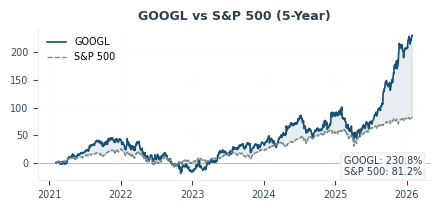

In [38]:
# 15. LLM EQUITY RESEARCH REPORT GENERATOR

!pip -q install google-generativeai

import google.generativeai as genai
import base64
from io import BytesIO
from datetime import datetime
from IPython.display import display, HTML
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import getpass
import os
import re

os.environ['GRPC_VERBOSITY'] = 'ERROR'

# CONFIGURATION
GEMINI_API_KEY = getpass.getpass("Enter GEMINI API Key: ")

if not GEMINI_API_KEY or len(GEMINI_API_KEY) < 10:
    raise ValueError("Invalid API key. Please run this cell again and enter a valid key.")

print("API Key accepted")

REPORT_DATE = datetime.now().strftime("%d %b %Y")
GENERATED_BY = "ANNISYA EQUITY AI AGENT"

genai.configure(api_key=GEMINI_API_KEY)

available = [m.name for m in genai.list_models()]

if 'models/gemini-2.5-flash' in available:
    model_id = 'gemini-2.5-flash'
elif 'models/gemini-3.0-flash' in available:
    model_id = 'gemini-3.0-flash'
else:
    model_id = 'gemini-flash-latest' 

model = genai.GenerativeModel(model_id)
print(f"✓ Using: {model_id}")

# COLLECT DATA FROM PREVIOUS CELLS

stock_data = {
    'ticker': TICKER,
    'industry': industry,
    'closing_price': last_close,
    'currency': currency,
    'market_cap': to_millions(market_cap),
    'beta': beta,
    'trailing_pe': trailing_pe,
    'last_close_date': last_close_date
}

dcf_data = {
    'bear': dcf_results['bear'],
    'base': dcf_results['base'],
    'bull': dcf_results['bull'],
    'weighted_price': price_dcf_weighted
}

multiples_data = {
    'pe_anchor': pe_anchor,
    'pe_bear': pe_bear,
    'pe_base': pe_base,
    'pe_bull': pe_bull,
    'eps_forward': eps_forward,
    'price_bear': price_pe_bear,
    'price_base': price_pe_base,
    'price_bull': price_pe_bull,
    'weighted_price': price_pe_weighted
}

final_data = {
    'current_price': last_close,
    'dcf_target': price_dcf_weighted,
    'multiples_target': price_pe_weighted,
    'blended_target': price_final,
    'upside_downside': rel_change,
    'recommendation': recommendation,
    'dcf_weight': DCF_WEIGHT,
    'multiples_weight': MULTIPLES_WEIGHT
}

wacc_data = {
    'risk_free_rate': wacc_components['risk_free_rate'],
    'market_return': wacc_components['market_return'],
    'mrp': wacc_components['market_risk_premium'],
    'beta': wacc_components['beta'],
    'cost_of_equity': wacc_components['cost_of_equity'],
    'cost_of_debt': wacc_components['cost_of_debt'],
    'tax_rate': wacc_components['tax_rate'],
    'debt_weight': wacc_components['weight_debt'],
    'equity_weight': wacc_components['weight_equity'],
    'wacc': wacc_components['wacc']
}

# Ratio Data 
ratio_data = {
    # Profitability
    'gross_margin': gross_margin_ttm,
    'operating_margin': operating_margin_ttm,
    'net_margin': net_margin_ttm,
    'ebitda_margin': ebitda_margin_ttm,
    'roa': roa_ttm,
    'roe': roe_ttm,
    'roic': roic_ttm,
    # Liquidity
    'current_ratio': current_ratio_ttm,
    'quick_ratio': quick_ratio_ttm,
    'cash_ratio': cash_ratio_ttm,
    'ocf_ratio': ocf_ratio_ttm,
    # Leverage
    'debt_to_equity': debt_to_equity_ttm,
    'debt_to_assets': debt_to_assets_ttm,
    'equity_multiplier': equity_multiplier_ttm,
    'interest_coverage': interest_coverage_ttm,
    'ebitda_coverage': ebitda_coverage_ttm,
    'ocf_to_debt': ocf_to_debt_ttm,
    'net_debt_to_ebitda': net_debt_to_ebitda_ttm,
    # Efficiency
    'asset_turnover': asset_turnover_ttm,
    'receivables_turnover': receivables_turnover_ttm,
    'dso': dso_ttm,
    # Cash Flow
    'ocf_margin': ocf_margin_ttm,
    'fcf_margin': fcf_margin_ttm,
    'cf_to_ni': cf_to_ni_ttm,
    'capex_to_ocf': capex_to_ocf_ttm,
    # Valuation
    'pe_ratio': trailing_pe,
    'pb_ratio': pb_ratio_ttm,
    'ps_ratio': ps_ratio_ttm,
    'ev_to_ebitda': ev_to_ebitda_ttm,
    'ev_to_sales': ev_to_sales_ttm,
    'market_cap_to_fcf': market_cap_to_fcf_ttm,
    'fcf_yield': fcf_yield_ttm
}

sensitivity_data = sens_matrix

# TEXT PROCESSING UTILITIES

def clean_title(text):
    """Extract a single clean title from LLM output."""
    text = re.sub(r'^(Here are|Here\'s|Title:|Report Title:|Option \d+:?|[\d]+\.)\s*', '', text, flags=re.IGNORECASE)
    
    lines = [l.strip() for l in text.split('\n') if l.strip()]
    if lines:
        title = lines[0]
        title = re.sub(r'\*\*(.+?)\*\*', r'\1', title)
        title = re.sub(r'\*(.+?)\*', r'\1', title)
        title = title.strip('"\'')
        title = re.sub(r'\s*\(\d+\s*words?\)\s*$', '', title, flags=re.IGNORECASE)
        return title
    return f"{TICKER}: Investment Analysis"

def markdown_to_html(text):
    """Convert markdown formatting to HTML."""
    text = re.sub(r'\*\*(.+?)\*\*', r'<strong>\1</strong>', text)
    text = re.sub(r'(?<!\*)\*([^\*]+?)\*(?!\*)', r'<em>\1</em>', text)
    return text

def convert_bullets_to_html(text):
    """Convert markdown bullet points to HTML <ul><li> tags."""
    lines = text.split('\n')
    result = []
    in_list = False
    
    for line in lines:
        stripped = line.strip()
        bullet_match = re.match(r'^[\*\-•]\s+(.+)$', stripped)
        
        if bullet_match:
            if not in_list:
                result.append('<ul>')
                in_list = True
            item_content = bullet_match.group(1)
            item_content = markdown_to_html(item_content)
            result.append(f'<li>{item_content}</li>')
        else:
            if in_list:
                result.append('</ul>')
                in_list = False
            if stripped:
                result.append(line)
    
    if in_list:
        result.append('</ul>')
    
    return '\n'.join(result)

def process_llm_text(text, convert_bullets=True):
    """Full processing pipeline for LLM output."""
    if not text:
        return text
    
    if convert_bullets:
        text = convert_bullets_to_html(text)
    
    text = markdown_to_html(text)
    
    return text

def count_words(text):
    """Count words in text, excluding HTML tags."""
    clean = re.sub(r'<[^>]+>', '', text)
    return len(clean.split())

def generate_performance_chart():
    """Generate the stock vs S&P 500 chart and return as base64"""
    
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365)
    
    stock_hist = yf.download(TICKER, start=start_date, end=end_date, progress=False)
    sp500_data = yf.download("^GSPC", start=start_date, end=end_date, progress=False)
    
    stock_norm = (stock_hist['Close'] / stock_hist['Close'].iloc[0] - 1) * 100
    sp500_norm = (sp500_data['Close'] / sp500_data['Close'].iloc[0] - 1) * 100
    
    stock_ret = float(stock_norm.iloc[-1].iloc[0]) if hasattr(stock_norm.iloc[-1], 'iloc') else float(stock_norm.iloc[-1])
    sp500_ret = float(sp500_norm.iloc[-1].iloc[0]) if hasattr(sp500_norm.iloc[-1], 'iloc') else float(sp500_norm.iloc[-1])
    
    COLORS = {
        'primary': '#2c3e50',
        'stock': '#1a5276',
        'sp500': '#7f8c8d',
        'text': '#34495e',
        'grid': '#ecf0f1',
        'background': '#f8f9fa'
    }
    
    fig, ax = plt.subplots(figsize=(4.5, 2.2))
    
    stock_values = stock_norm.values.flatten()
    sp500_values = sp500_norm.values.flatten()
    
    ax.plot(stock_norm.index, stock_values, color=COLORS['stock'], linewidth=1.2, label=TICKER)
    ax.plot(sp500_norm.index, sp500_values, color=COLORS['sp500'], linewidth=1.0, linestyle='--', label='S&P 500')
    
    ax.fill_between(stock_norm.index, stock_values, sp500_values, 
                    where=(stock_values >= sp500_values), color=COLORS['stock'], alpha=0.1)
    ax.fill_between(stock_norm.index, stock_values, sp500_values, 
                    where=(stock_values < sp500_values), color=COLORS['sp500'], alpha=0.1)
    
    ax.axhline(y=0, color=COLORS['text'], linewidth=0.5, alpha=0.5)
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, linestyle='-', alpha=0.2, color=COLORS['grid'])
    ax.set_title(f'{TICKER} vs S&P 500 (5-Year)', fontsize=9, fontweight='bold', color=COLORS['primary'])
    ax.tick_params(axis='both', labelsize=7, colors=COLORS['text'])
    ax.legend(loc='upper left', fontsize=7, frameon=False)
    
    textstr = f'{TICKER}: {stock_ret:.1f}%\nS&P 500: {sp500_ret:.1f}%'
    ax.annotate(textstr, xy=(0.98, 0.02), xycoords='axes fraction', fontsize=7,
                va='bottom', ha='right', color=COLORS['primary'],
                bbox=dict(boxstyle='round,pad=0.3', facecolor=COLORS['background'], edgecolor=COLORS['grid']))
    
    plt.tight_layout()
    
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', dpi=100, facecolor='white')
    buffer.seek(0)
    img_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.close()
    
    return img_base64, stock_ret, sp500_ret


# LLM NARRATIVE

def generate_llm_content():
    """Use Gemini to generate report narratives with improved prompts"""
    
    overview_prompt = f"""You are a senior equity research analyst at a top investment bank. Write a comprehensive overview for {TICKER} ({stock_data['industry']} sector).

CRITICAL INSTRUCTIONS:
- Write in FLOWING, CONNECTED PROSE with smooth transitions between sentences
- Do NOT use bullet points, numbered lists, or markdown formatting (no **, no *)
- STRICT WORD LIMIT: 100-140 words total (this is mandatory)
- Each sentence should logically connect to the next

CONTENT REQUIREMENTS:

Business Overview (first paragraph, ~70 words):
- Describe {TICKER}'s core business model and main revenue streams
- Name specific operating segments and key products/services
- Mention market position and competitive advantages

Industry Overview (second paragraph, ~70 words):
- Describe the industry landscape {TICKER} operates in
- Mention key trends and main competitors by name
- Note any regulatory considerations

FORMAT: Write exactly 2 paragraphs. Start the first with "Business Overview:" and the second with "Industry Overview:" (no asterisks or bold markers)."""

    if final_data['recommendation'] == 'BUY':
        risk_prompt = f"""END WITH "Risks to our price valuation include:" followed by exactly 3 bullet points (use - for bullets) of DOWNSIDE RISKS specific to {TICKER}. These are factors that could prevent the stock from reaching our target price. Each risk should be 1 sentence."""
    elif final_data['recommendation'] == 'SELL':
        risk_prompt = f"""END WITH "Upside risks to our thesis include:" followed by exactly 3 bullet points (use - for bullets) of UPSIDE RISKS specific to {TICKER}. These are factors that could cause the stock to outperform our expectations and prove our sell recommendation wrong. Each risk should be 1 sentence."""
    else:  
        risk_prompt = f"""END WITH "Key risks to monitor include:" followed by exactly 3 bullet points (use - for bullets) of KEY RISKS specific to {TICKER}. These are factors that could move the stock significantly in either direction. Each risk should be 1 sentence."""

    investment_prompt = f"""You are a senior equity research analyst. Write a detailed Investment Overview for {TICKER}.

CRITICAL INSTRUCTIONS:
- Write in FLOWING, CONNECTED PROSE for the main analysis
- Do NOT use markdown formatting (no ** or * symbols)
- Use simple bullet points (starting with -) ONLY for the Risks section at the end
- STRICT WORD LIMIT: 130-170 words total

CONTENT TO INCLUDE (weave naturally into flowing paragraphs):

1. Valuation Methodology: Our analysis employs a blended approach combining DCF ({final_data['dcf_weight']:.0%} weight) and Forward P/E Multiples ({final_data['multiples_weight']:.0%} weight).

2. DCF Analysis: WACC of {wacc_data['wacc']:.2%}, Cost of Equity {wacc_data['cost_of_equity']:.2%}, Beta {wacc_data['beta']:.2f}, 5-year projection with {dcf_data['base']['terminal_growth']:.1%} terminal growth, yielding ${final_data['dcf_target']:,.2f} target.

3. Multiples Analysis: Using an industry average Forward P/E adjusted across a range of {multiples_data['pe_bear']:.1f}x - {multiples_data['pe_bull']:.1f}x, applied to Forward EPS of ${multiples_data['eps_forward']:.2f}, yielding a probability-weighted target of ${final_data['multiples_target']:,.2f}.

4. Key Investment Drivers: Identify 2-3 specific growth drivers for {TICKER}

5. Conclusion: Current ${final_data['current_price']:.2f}, Blended Target ${final_data['blended_target']:.2f}, {final_data['upside_downside']:+.1%} upside/downside, {final_data['recommendation']} recommendation.

{risk_prompt}"""

    conclusion_prompt = f"""Write a brief investment conclusion for {TICKER}.

CRITICAL INSTRUCTIONS:
- Write exactly 2-3 sentences in flowing prose
- Do NOT use bullet points or markdown formatting (no ** or *)
- STRICT WORD LIMIT: 50-70 words

KEY POINTS TO COVER:
- Recommendation: {final_data['recommendation']}
- Target Price: ${final_data['blended_target']:.2f} ({final_data['upside_downside']:+.1%} from ${final_data['current_price']:.2f})
- Brief thesis summary
- One forward-looking statement about catalysts to monitor

Write in professional equity research style."""

    title_prompt = f"""Generate ONE equity research report title for {TICKER}.

RULES:
- Output ONLY the title itself - nothing else
- No explanations, no options, no numbering, no quotes
- Maximum 8 words
- Do NOT include the recommendation (BUY/HOLD/SELL) in the title
- Make it insightful and professional
- Do NOT use asterisks or any formatting

Example format: "Company Name: Key Investment Theme"

Your title:"""

    try:
        overview_response = model.generate_content(overview_prompt)
        investment_response = model.generate_content(investment_prompt)
        conclusion_response = model.generate_content(conclusion_prompt)
        title_response = model.generate_content(title_prompt)
        
        overview_text = process_llm_text(overview_response.text, convert_bullets=False)
        investment_text = process_llm_text(investment_response.text, convert_bullets=True)
        conclusion_text = process_llm_text(conclusion_response.text, convert_bullets=False)
        title_text = clean_title(title_response.text)
        
        return {
            'overview': overview_text,
            'investment': investment_text,
            'conclusion': conclusion_text,
            'title': title_text
        }
    except Exception as e:
        print(f"LLM Error: {e}")
        return {
            'overview': f"""<strong>Business Overview:</strong> {TICKER} is a leading company in the {stock_data['industry']} sector with diversified revenue streams across multiple business segments. The company maintains strong market position through technological innovation and scale advantages, serving customers globally while investing in strategic growth initiatives.

<strong>Industry Overview:</strong> The {stock_data['industry']} industry continues evolving with digital transformation and changing consumer preferences. Key competitors include major technology players, while regulatory oversight remains an important consideration for industry participants.""",
            'investment': f"""Our valuation framework employs a blended methodology combining Discounted Cash Flow analysis ({final_data['dcf_weight']:.0%} weight) with Forward P/E Multiples ({final_data['multiples_weight']:.0%} weight). The DCF analysis utilizes a WACC of {wacc_data['wacc']:.2%}, derived from Cost of Equity of {wacc_data['cost_of_equity']:.2%} and Beta of {wacc_data['beta']:.2f}, with terminal growth of {dcf_data['base']['terminal_growth']:.1%}, yielding a fair value of ${final_data['dcf_target']:,.2f}. Our multiples analysis anchors on industry P/E of {multiples_data['pe_anchor']:.1f}x applied to forward EPS of ${multiples_data['eps_forward']:.2f}, generating a target of ${final_data['multiples_target']:,.2f}. Key investment drivers include revenue growth from market expansion, margin improvement through operational efficiency, and strong competitive positioning. Our blended target of ${final_data['blended_target']:.2f} implies {final_data['upside_downside']:+.1%} from current ${final_data['current_price']:.2f}, supporting our {final_data['recommendation']} recommendation.

Risks to our price valuation include:
<ul>
<li>Economic downturn could negatively impact demand and compress margins</li>
<li>Increased competition may pressure market share and pricing power</li>
<li>Regulatory changes could materially impact profitability</li>
</ul>""",
            'conclusion': f"""We maintain a {final_data['recommendation']} rating on {TICKER} with a target price of ${final_data['blended_target']:.2f}, representing {final_data['upside_downside']:+.1%} from current levels. The company's strong market position and growth initiatives support our thesis, with earnings releases and strategic announcements as key catalysts to monitor.""",
            'title': f"{TICKER}: Strategic Value; {final_data['recommendation']}"
        }

# HTML REPORT 

def generate_html_report(llm_content, chart_base64, stock_ret, sp500_ret):
    """Generate the professional 2-page HTML report"""
    
    rec_color = '#27ae60' if final_data['recommendation'] == 'BUY' else '#e74c3c' if final_data['recommendation'] == 'SELL' else '#f39c12'
    
    def fmt_ratio(val, suffix='x', decimals=2):
        if val is None or (isinstance(val, float) and (np.isnan(val) or np.isinf(val))):
            return 'N/A'
        return f"{val:.{decimals}f}{suffix}"
    
    def fmt_pct(val, decimals=1):
        if val is None or (isinstance(val, float) and (np.isnan(val) or np.isinf(val))):
            return 'N/A'
        return f"{val:.{decimals}f}%"
    
    def get_heatmap_color(value, min_val, max_val):
        """Generate soft pastel heatmap color: green (high) -> yellow (mid) -> red (low)"""
        if max_val == min_val:
            return '#fef9e7'  
        
        normalized = (value - min_val) / (max_val - min_val)
        
        if normalized >= 0.8:
            return '#a8d5a2' 
        elif normalized >= 0.6:
            return '#c9e4a6'  
        elif normalized >= 0.4:
            return '#f0f0a0' 
        elif normalized >= 0.2:
            return '#f5d5a0'  
        else:
            return '#f4a6a6'  
    
    sens_rows = len(sensitivity_data)
    sens_cols = len(sensitivity_data.columns)
    
    sens_values = []
    for i in range(sens_rows):
        for j in range(sens_cols):
            try:
                sens_values.append(float(sensitivity_data.iloc[i, j]))
            except:
                pass
    sens_min = min(sens_values) if sens_values else 0
    sens_max = max(sens_values) if sens_values else 1
    
    base_row = sens_rows // 2
    base_col = sens_cols // 2
    
    def sens_cell(row, col, is_base=False):
        val = sensitivity_data.iloc[row, col]
        color = get_heatmap_color(val, sens_min, sens_max)
        bold = 'font-weight:bold;' if is_base else ''
        return f'<td class="value-cell" style="background:{color};{bold}">${val:,.0f}</td>'
    
    def generate_sensitivity_table():
        header_cells = ''.join([f'<th class="value-cell">{col}</th>' for col in sensitivity_data.columns])
        header_row = f'<tr><th>TG \\ WACC</th>{header_cells}</tr>'
        
        data_rows = ''
        for i in range(sens_rows):
            tg_value = sensitivity_data.index[i]
            if isinstance(tg_value, (int, float)):
                if tg_value < 1:
                    tg_label = f'{tg_value:.1%}'  
                else:
                    tg_label = f'{tg_value:.1f}%'  
            else:
                tg_label = str(tg_value)
            
            cells = ''
            for j in range(sens_cols):
                is_base = (i == base_row and j == base_col)
                cells += sens_cell(i, j, is_base)
            
            data_rows += f'<tr><td>{tg_label}</td>{cells}</tr>'
        
        return header_row + data_rows
    
    sensitivity_table_html = generate_sensitivity_table()
    
    overview_html = llm_content['overview']
    overview_html = re.sub(r'(?:^|\n)\s*Business Overview:\s*', '<p><strong>Business Overview:</strong> ', overview_html, flags=re.IGNORECASE)
    overview_html = re.sub(r'(?:^|\n)\s*Industry Overview:\s*', '</p><p><strong>Industry Overview:</strong> ', overview_html, flags=re.IGNORECASE)
    if not overview_html.strip().endswith('</p>'):
        overview_html += '</p>'
    
    investment_html = llm_content['investment']
    investment_html = re.sub(
        r'(Risks to (?:our )?price (?:valuation|target)[^:]*:|Upside risks to our thesis include:|Key risks to monitor include:)',
        r'</p><p><strong>\1</strong></p>',
        investment_html,
        flags=re.IGNORECASE
    )
    
    html = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>{stock_data['ticker']} Equity Research Report</title>
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@400;500;700&family=Roboto+Condensed:wght@400;500;700&family=Montserrat:wght@400;500;700&display=swap" rel="stylesheet">
    <style>
        @page {{
            size: A4;
            margin: 0;
        }}
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        body {{
            font-family: 'Roboto', 'Segoe UI', Arial, sans-serif;
            font-size: 9pt;
            line-height: 1.4;
            color: #2c3e50;
            background: #5a6a7a;
        }}
        .page {{
            width: 210mm;
            min-height: 297mm;
            margin: 15px auto;
            padding: 12mm;
            background: white;
            position: relative;
        }}
        .header {{
            background: linear-gradient(135deg, #2c3e50 0%, #1a252f 100%);
            color: white;
            padding: 12px 15px;
            margin: -12mm -12mm 10px -12mm;
            display: flex;
            justify-content: space-between;
            align-items: center;
        }}
        .header-left {{
            display: flex;
            flex-direction: column;
        }}
        .header-label {{
            font-family: 'Roboto Condensed', 'Montserrat', 'Roboto', Arial, sans-serif;
            font-size: 8pt;
            color: #bdc3c7;
            text-transform: uppercase;
            letter-spacing: 1px;
        }}
        .header-right {{
            font-family: 'Roboto Condensed', 'Montserrat', 'Roboto', Arial, sans-serif;
            text-align: right;
            font-size: 10pt;
            color: #bdc3c7;
        }}
        .company-name {{
            font-family: 'Roboto Condensed', 'Montserrat', 'Roboto', Arial, sans-serif;
            font-size: 18pt;
            font-weight: bold;
            margin: 3px 0;
        }}
        .report-title {{
            font-family: 'Roboto Condensed', 'Montserrat', 'Roboto', Arial, sans-serif;
            font-size: 11pt;
            color: #ecf0f1;
            font-style: italic;
        }}
        .two-column {{
            display: flex;
            gap: 15px;
        }}
        .left-column {{
            flex: 0 0 45%;
        }}
        .right-column {{
            flex: 0 0 53%;
        }}
        .section-title {{
            font-size: 10pt;
            font-weight: bold;
            color: #8b0000;
            border-bottom: 2px solid #8b0000;
            padding-bottom: 3px;
            margin: 10px 0 8px 0;
        }}
        .subsection-title {{
            font-size: 9pt;
            font-weight: bold;
            color: #2c3e50;
            margin: 8px 0 5px 0;
        }}
        .narrative {{
            font-family: 'Roboto', 'Segoe UI', Arial, sans-serif;
            text-align: justify;
            font-size: 8.5pt;
            color: #34495e;
            line-height: 1.5;
        }}
        .narrative p {{
            margin-bottom: 8px;
        }}
        .narrative strong {{
            color: #2c3e50;
        }}
        .narrative ul {{
            margin: 5px 0 8px 15px;
            padding: 0;
            list-style-type: disc;
        }}
        .narrative li {{
            margin-bottom: 4px;
            font-size: 8pt;
            line-height: 1.4;
        }}
        
        /* CONCLUSION BOX WITH BORDER */
        .conclusion-box {{
            background: #f8f9fa;
            border: 1px solid #dce1e4;
            border-left: 4px solid #2c3e50;
            padding: 10px 12px;
            margin: 10px 0;
        }}
        .conclusion-title {{
            font-size: 9pt;
            font-weight: bold;
            color: #2c3e50;
            margin-bottom: 5px;
        }}
        .conclusion-text {{
            font-family: 'Roboto', 'Segoe UI', Arial, sans-serif;
            font-size: 8.5pt;
            line-height: 1.5;
            color: #34495e;
            text-align: justify;
        }}
        
        table {{
            width: 100%;
            border-collapse: collapse;
            font-size: 8pt;
            margin: 5px 0;
        }}
        th {{
            background: #2c3e50;
            color: white;
            padding: 4px 6px;
            text-align: left;
            font-weight: bold;
        }}
        td {{
            padding: 3px 6px;
            border-bottom: 1px solid #ecf0f1;
        }}
        tr:nth-child(even) {{
            background: #f8f9fa;
        }}
        .value-cell {{
            text-align: right;
            font-family: 'Roboto', Arial, sans-serif;
        }}
        .recommendation-box {{
            background: {rec_color};
            color: white;
            padding: 8px 12px;
            text-align: center;
            font-weight: bold;
            font-size: 12pt;
            border-radius: 4px;
            margin: 8px 0;
        }}
        .chart-container {{
            text-align: center;
            margin: 8px 0;
        }}
        .chart-container img {{
            max-width: 100%;
            height: auto;
            border: 1px solid #ecf0f1;
            border-radius: 4px;
        }}
        .chart-title {{
            font-size: 8pt;
            color: #7f8c8d;
            margin-top: 3px;
        }}
        .grid-2col {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 12px;
        }}
        .grid-3col {{
            display: grid;
            grid-template-columns: 1fr 1fr 1fr;
            gap: 10px;
        }}
        .ratio-table {{
            font-size: 7pt;
        }}
        .ratio-table th {{
            background: #1a5276;
            font-size: 7pt;
            padding: 3px 4px;
        }}
        .ratio-table td {{
            padding: 2px 4px;
            font-size: 7pt;
        }}
        .small-table {{
            font-size: 7.5pt;
        }}
        .small-table th {{
            padding: 3px 5px;
            font-size: 7.5pt;
        }}
        .small-table td {{
            padding: 2px 5px;
        }}
        .sensitivity-table th {{
            background: #4e79a7;
        }}
        .highlight-green {{
            background: #d5f5e3;
        }}
        .highlight-red {{
            background: #fadbd8;
        }}
        .highlight-yellow {{
            background: #fef9e7;
        }}
        .footer {{
            position: absolute;
            bottom: 12mm;
            left: 12mm;
            right: 12mm;
            font-size: 7pt;
            color: #7f8c8d;
            border-top: 1px solid #ecf0f1;
            padding-top: 5px;
        }}
        
        @media print {{
            body {{
                background: white;
                -webkit-print-color-adjust: exact !important;
                print-color-adjust: exact !important;
                color-adjust: exact !important;
            }}
            .page {{
                margin: 0;
                -webkit-print-color-adjust: exact !important;
                print-color-adjust: exact !important;
            }}
            * {{
                -webkit-print-color-adjust: exact !important;
                print-color-adjust: exact !important;
                color-adjust: exact !important;
            }}
            .header {{
                -webkit-print-color-adjust: exact !important;
                print-color-adjust: exact !important;
            }}
            th, .recommendation-box, .conclusion-box {{
                -webkit-print-color-adjust: exact !important;
                print-color-adjust: exact !important;
            }}
        }}
    </style>
</head>
<body>

<!-- PAGE 1 -->
<div class="page">
    <div class="header">
        <div class="header-left">
            <div class="header-label">Equity Research Report</div>
            <div class="company-name">{stock_data['ticker']} - {stock_data['industry']}</div>
            <div class="report-title">{llm_content['title']}</div>
        </div>
        <div class="header-right">
            <div>{REPORT_DATE}</div>
            <div>Generated by: {GENERATED_BY}</div>
            <div>Page 1</div>
        </div>
    </div>
    
    <div class="two-column">
        <div class="left-column">
            <div class="section-title">Overview</div>
            <div class="narrative">
                {overview_html}
            </div>
            
            <div class="section-title">Investment Overview</div>
            <div class="narrative">
                <p>{investment_html}</p>
            </div>
            
            <div class="conclusion-box">
                <div class="conclusion-title">Investment Conclusion</div>
                <div class="conclusion-text">{llm_content['conclusion']}</div>
            </div>
        </div>
        
        <div class="right-column">
            <div class="section-title">Stock Overview</div>
            <table>
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>Ticker</td><td class="value-cell">{stock_data['ticker']}</td></tr>
                <tr><td>Industry/Sector</td><td class="value-cell">{stock_data['industry']}</td></tr>
                <tr><td>Closing Price</td><td class="value-cell">{stock_data['closing_price']:,.2f} {stock_data['currency']}</td></tr>
                <tr><td>Market Cap</td><td class="value-cell">{stock_data['market_cap']:,.0f} {stock_data['currency']}m</td></tr>
                <tr><td>Beta</td><td class="value-cell">{stock_data['beta']:.2f}</td></tr>
                <tr><td>P/E (TTM)</td><td class="value-cell">{stock_data['trailing_pe']:.2f}x</td></tr>
            </table>
            <div style="font-size: 7pt; color: #95a5a6; margin-top: 3px;">Closing price as of {stock_data['last_close_date']}</div>
            
            <div class="chart-container">
                <img src="data:image/png;base64,{chart_base64}" alt="Performance Chart">
                <div class="chart-title">Source: Yahoo Finance</div>
            </div>
            
            <div class="section-title">Final Valuation & Recommendation</div>
            
            <div class="subsection-title">Scenario Analysis</div>
            <table class="small-table">
                <tr><th>Scenario</th><th class="value-cell">DCF Price</th><th class="value-cell">Multiples Price</th></tr>
                <tr><td>Bear Case</td><td class="value-cell">${dcf_data['bear']['share_price']:,.2f}</td><td class="value-cell">${multiples_data['price_bear']:,.2f}</td></tr>
                <tr><td>Base Case</td><td class="value-cell">${dcf_data['base']['share_price']:,.2f}</td><td class="value-cell">${multiples_data['price_base']:,.2f}</td></tr>
                <tr><td>Bull Case</td><td class="value-cell">${dcf_data['bull']['share_price']:,.2f}</td><td class="value-cell">${multiples_data['price_bull']:,.2f}</td></tr>
                <tr style="font-weight: bold; background: #eaecee;"><td>Prob-Weighted</td><td class="value-cell">${dcf_data['weighted_price']:,.2f}</td><td class="value-cell">${multiples_data['weighted_price']:,.2f}</td></tr>
            </table>
            
            <div class="subsection-title">Final Investment Recommendation</div>
            <table class="small-table">
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>Current Price</td><td class="value-cell">${final_data['current_price']:,.2f}</td></tr>
                <tr><td>DCF Target ({final_data['dcf_weight']:.0%} weight)</td><td class="value-cell">${final_data['dcf_target']:,.2f}</td></tr>
                <tr><td>Multiples Target ({final_data['multiples_weight']:.0%} weight)</td><td class="value-cell">${final_data['multiples_target']:,.2f}</td></tr>
                <tr style="font-weight: bold;"><td>Blended Target Price</td><td class="value-cell">${final_data['blended_target']:,.2f}</td></tr>
                <tr><td>Upside / Downside</td><td class="value-cell">{final_data['upside_downside']:+.1%}</td></tr>
            </table>
            <div class="recommendation-box">{final_data['recommendation']}</div>
        </div>
    </div>
</div>

<!-- PAGE 2 -->
<div class="page">
    <div class="header">
        <div class="header-left">
            <div class="header-label">Equity Research Report</div>
            <div class="company-name">{stock_data['ticker']} - Financial Analysis</div>
        </div>
        <div class="header-right">
            <div>{REPORT_DATE}</div>
            <div>Page 2</div>
        </div>
    </div>
    
    <div class="section-title">Financial Ratio Analysis (TTM)</div>
    
    <!-- ROW 1: Profitability, Liquidity, Leverage -->
    <div class="grid-3col">
        <div>
            <div class="subsection-title">Profitability</div>
            <table class="ratio-table">
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>Gross Margin</td><td class="value-cell">{fmt_pct(ratio_data['gross_margin'])}</td></tr>
                <tr><td>Operating Margin</td><td class="value-cell">{fmt_pct(ratio_data['operating_margin'])}</td></tr>
                <tr><td>Net Margin</td><td class="value-cell">{fmt_pct(ratio_data['net_margin'])}</td></tr>
                <tr><td>EBITDA Margin</td><td class="value-cell">{fmt_pct(ratio_data['ebitda_margin'])}</td></tr>
                <tr><td>ROA</td><td class="value-cell">{fmt_pct(ratio_data['roa'])}</td></tr>
                <tr><td>ROE</td><td class="value-cell">{fmt_pct(ratio_data['roe'])}</td></tr>
                <tr><td>ROIC</td><td class="value-cell">{fmt_pct(ratio_data['roic'])}</td></tr>
            </table>
        </div>
        <div>
            <div class="subsection-title">Liquidity</div>
            <table class="ratio-table">
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>Current Ratio</td><td class="value-cell">{fmt_ratio(ratio_data['current_ratio'])}</td></tr>
                <tr><td>Quick Ratio</td><td class="value-cell">{fmt_ratio(ratio_data['quick_ratio'])}</td></tr>
                <tr><td>Cash Ratio</td><td class="value-cell">{fmt_ratio(ratio_data['cash_ratio'])}</td></tr>
                <tr><td>OCF Ratio</td><td class="value-cell">{fmt_ratio(ratio_data['ocf_ratio'])}</td></tr>
            </table>
        </div>
        <div>
            <div class="subsection-title">Leverage</div>
            <table class="ratio-table">
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>Debt/Equity</td><td class="value-cell">{fmt_ratio(ratio_data['debt_to_equity'])}</td></tr>
                <tr><td>Debt/Assets</td><td class="value-cell">{fmt_ratio(ratio_data['debt_to_assets'])}</td></tr>
                <tr><td>Equity Multiplier</td><td class="value-cell">{fmt_ratio(ratio_data['equity_multiplier'])}</td></tr>
                <tr><td>Interest Coverage</td><td class="value-cell">{fmt_ratio(ratio_data['interest_coverage'])}</td></tr>
                <tr><td>EBITDA Coverage</td><td class="value-cell">{fmt_ratio(ratio_data['ebitda_coverage'])}</td></tr>
                <tr><td>Net Debt/EBITDA</td><td class="value-cell">{fmt_ratio(ratio_data['net_debt_to_ebitda'])}</td></tr>
            </table>
        </div>
    </div>
    
    <!-- ROW 2: Efficiency, Cash Flow, Valuation -->
    <div class="grid-3col" style="margin-top: 8px;">
        <div>
            <div class="subsection-title">Efficiency</div>
            <table class="ratio-table">
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>Asset Turnover</td><td class="value-cell">{fmt_ratio(ratio_data['asset_turnover'])}</td></tr>
                <tr><td>Receivables Turnover</td><td class="value-cell">{fmt_ratio(ratio_data['receivables_turnover'])}</td></tr>
                <tr><td>Days Sales Outstanding</td><td class="value-cell">{ratio_data['dso']:.1f} days</td></tr>
            </table>
        </div>
        <div>
            <div class="subsection-title">Cash Flow</div>
            <table class="ratio-table">
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>OCF Margin</td><td class="value-cell">{fmt_pct(ratio_data['ocf_margin'])}</td></tr>
                <tr><td>FCF Margin</td><td class="value-cell">{fmt_pct(ratio_data['fcf_margin'])}</td></tr>
                <tr><td>CF to Net Income</td><td class="value-cell">{fmt_ratio(ratio_data['cf_to_ni'])}</td></tr>
                <tr><td>CapEx / OCF</td><td class="value-cell">{fmt_pct(ratio_data['capex_to_ocf'])}</td></tr>
            </table>
        </div>
        <div>
            <div class="subsection-title">Valuation</div>
            <table class="ratio-table">
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>P/E (TTM)</td><td class="value-cell">{fmt_ratio(ratio_data['pe_ratio'])}</td></tr>
                <tr><td>P/B</td><td class="value-cell">{fmt_ratio(ratio_data['pb_ratio'])}</td></tr>
                <tr><td>P/S</td><td class="value-cell">{fmt_ratio(ratio_data['ps_ratio'])}</td></tr>
                <tr><td>EV/EBITDA</td><td class="value-cell">{fmt_ratio(ratio_data['ev_to_ebitda'])}</td></tr>
                <tr><td>EV/Sales</td><td class="value-cell">{fmt_ratio(ratio_data['ev_to_sales'])}</td></tr>
                <tr><td>FCF Yield</td><td class="value-cell">{fmt_pct(ratio_data['fcf_yield'])}</td></tr>
            </table>
        </div>
    </div>
    
    <div class="section-title">WACC Calculation</div>
    <div class="grid-2col">
        <table class="small-table">
            <tr><th>Component</th><th class="value-cell">Value</th></tr>
            <tr><td>Risk-Free Rate</td><td class="value-cell">{wacc_data['risk_free_rate']:.2%}</td></tr>
            <tr><td>Market Risk Premium</td><td class="value-cell">{wacc_data['mrp']:.2%}</td></tr>
            <tr><td>Beta</td><td class="value-cell">{wacc_data['beta']:.2f}</td></tr>
            <tr><td>Cost of Equity</td><td class="value-cell">{wacc_data['cost_of_equity']:.2%}</td></tr>
            <tr><td>Cost of Debt (after-tax)</td><td class="value-cell">{wacc_data['cost_of_debt']*(1-wacc_data['tax_rate']):.2%}</td></tr>
        </table>
        <table class="small-table">
            <tr><th>Component</th><th class="value-cell">Value</th></tr>
            <tr><td>Equity Weight</td><td class="value-cell">{wacc_data['equity_weight']:.1%}</td></tr>
            <tr><td>Debt Weight</td><td class="value-cell">{wacc_data['debt_weight']:.1%}</td></tr>
            <tr style="font-weight: bold; background: #eaecee;"><td>WACC</td><td class="value-cell">{wacc_data['wacc']:.2%}</td></tr>
        </table>
    </div>
    
    <div class="section-title">DCF Valuation Summary</div>
    <table class="small-table">
        <tr><th>Metric</th><th class="value-cell">Bear Case</th><th class="value-cell">Base Case</th><th class="value-cell">Bull Case</th></tr>
        <tr><td>Terminal Growth</td><td class="value-cell">{dcf_data['bear']['terminal_growth']:.1%}</td><td class="value-cell">{dcf_data['base']['terminal_growth']:.1%}</td><td class="value-cell">{dcf_data['bull']['terminal_growth']:.1%}</td></tr>
        <tr><td>PV(FCFF)</td><td class="value-cell">${to_millions(dcf_data['bear']['pv_fcff']):,.0f}m</td><td class="value-cell">${to_millions(dcf_data['base']['pv_fcff']):,.0f}m</td><td class="value-cell">${to_millions(dcf_data['bull']['pv_fcff']):,.0f}m</td></tr>
        <tr><td>PV(Terminal Value)</td><td class="value-cell">${to_millions(dcf_data['bear']['pv_terminal_value']):,.0f}m</td><td class="value-cell">${to_millions(dcf_data['base']['pv_terminal_value']):,.0f}m</td><td class="value-cell">${to_millions(dcf_data['bull']['pv_terminal_value']):,.0f}m</td></tr>
        <tr><td>Enterprise Value</td><td class="value-cell">${to_millions(dcf_data['bear']['enterprise_value']):,.0f}m</td><td class="value-cell">${to_millions(dcf_data['base']['enterprise_value']):,.0f}m</td><td class="value-cell">${to_millions(dcf_data['bull']['enterprise_value']):,.0f}m</td></tr>
        <tr><td>Equity Value</td><td class="value-cell">${to_millions(dcf_data['bear']['equity_value']):,.0f}m</td><td class="value-cell">${to_millions(dcf_data['base']['equity_value']):,.0f}m</td><td class="value-cell">${to_millions(dcf_data['bull']['equity_value']):,.0f}m</td></tr>
        <tr style="font-weight: bold; background: #eaecee;"><td>Share Price</td><td class="value-cell">${dcf_data['bear']['share_price']:,.2f}</td><td class="value-cell">${dcf_data['base']['share_price']:,.2f}</td><td class="value-cell">${dcf_data['bull']['share_price']:,.2f}</td></tr>
        <tr><td>Probability</td><td class="value-cell">10%</td><td class="value-cell">80%</td><td class="value-cell">10%</td></tr>
    </table>
    
    <div class="grid-2col" style="margin-top: 8px;">
        <div>
            <div class="section-title">Sensitivity Analysis (Base Case)</div>
            <table class="sensitivity-table small-table">
                {sensitivity_table_html}
            </table>
        </div>
        <div>
            <div class="section-title">Multiples Valuation Summary</div>
            <table class="small-table">
                <tr><th>Metric</th><th class="value-cell">Value</th></tr>
                <tr><td>Industry Anchor Forward P/E</td><td class="value-cell">{multiples_data['pe_anchor']:.1f}x</td></tr>
                <tr><td>Forward EPS</td><td class="value-cell">${multiples_data['eps_forward']:.2f}</td></tr>
                <tr><td>Bear P/E (10%)</td><td class="value-cell">{multiples_data['pe_bear']:.1f}x</td></tr>
                <tr><td>Base P/E (80%)</td><td class="value-cell">{multiples_data['pe_base']:.1f}x</td></tr>
                <tr><td>Bull P/E (10%)</td><td class="value-cell">{multiples_data['pe_bull']:.1f}x</td></tr>
                <tr style="font-weight: bold; background: #eaecee;"><td>Prob-Weighted Target</td><td class="value-cell">${multiples_data['weighted_price']:,.2f}</td></tr>
            </table>
        </div>
    </div>
    
    <div class="footer">
        <strong>Disclaimer:</strong> This report is generated by an AI model for educational purposes only. It does not constitute investment advice. 
        All data sourced from Yahoo Finance. Past performance is not indicative of future results. Generated by {GENERATED_BY} on {REPORT_DATE}.
    </div>
</div>

</body>
</html>
"""
    return html


# PREVIEW

print("GENERATING EQUITY RESEARCH REPORT")

print("\n1. Generating LLM content via Gemini...")
llm_content = generate_llm_content()

chart_base64, stock_ret, sp500_ret = generate_performance_chart()

print("\n2. Building HTML report...")
html_report = generate_html_report(llm_content, chart_base64, stock_ret, sp500_ret)
print("   HTML report generated")

html_filename = f"Equity_Research_Report_{TICKER}_{datetime.now().strftime('%Y%m%d')}.html"
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(html_report)
print(f"\n4. Report saved: {html_filename}")

print("REPORT GENERATION COMPLETE")

display(HTML(html_report))

In [39]:
from IPython.display import FileLink
display(FileLink(html_filename))

/Users/annisya/Desktop/UCL/Introduction to Financial Markets/Assestment Group Assignment/Annisya_Submission/Equity_Research_Report_GOOGL_20260201.html